# Análisis EDA - Póliza de caravanas

## Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import scipy.stats as stats
from scipy.stats import chi2_contingency
import warnings

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

## Funciones

In [2]:
def cramers_v(var1,var2):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix: tabla creada con pd.crosstab()
    
    """
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    chi2 = stats.chi2_contingency(crosstab)[0]
    n = crosstab.sum()
    phi2 = chi2 / n
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return None

def plot_feature(df, col_name, target):
    """
    Visualize a variable with and without faceting on the loan status.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    
    sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
    data.columns = [i, target, 'proportion']
    #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
    sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
    ax2.set_ylabel(target+' fraction')
    ax2.set_title(target)
    plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    
def plot_feature2(df, col_name, col_name2):
    """
    Visualize a variable with and without faceting on the loan status.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    
    sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    sns.countplot(df[col_name2], order=sorted(df[col_name2].unique()), color='#5975A4', saturation=1, ax=ax2)
    ax2.set_xlabel(col_name2)
    ax2.set_ylabel('Count')
    ax2.set_title(col_name2+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)
    
    plt.tight_layout()
    
def get_deviation_of_mean_perc(df, list_var_numeric, target, multiplier):
    """
    Devuelve el porcentaje de valores que exceden del intervalo de confianza
    :type series:
    :param multiplier:
    :return:
    """
    pd_final = pd.DataFrame()
    
    for i in list_var_numeric:
        
        series_mean = df[i].mean()
        series_std = df[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = df[i].size
        
        perc_goods = df[i][(df[i] >= left) & (df[i] <= right)].size/size_s
        perc_excess = df[i][(df[i] < left) | (df[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(df[target][(df[i] < left) | (df[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = df[i][(df[i] < left) | (df[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final

## Lectura del diccionario

In [3]:
dictionary = pd.read_excel('../data/dictionary_eda.xlsx', sheet_name='dictionary_eda')
L0 = pd.read_excel('../data/dictionary_eda.xlsx', sheet_name='L0')
L1 = pd.read_excel('../data/dictionary_eda.xlsx', sheet_name='L1')
L2 = pd.read_excel('../data/dictionary_eda.xlsx', sheet_name='L2')
L3 = pd.read_excel('../data/dictionary_eda.xlsx', sheet_name='L3')
L4 = pd.read_excel('../data/dictionary_eda.xlsx', sheet_name='L4')

In [4]:
dictionary.head()

N        ID                    Desc Escale
0  0   MOSTYPE        Customer Subtype     L0
1  1  MAANTHUI        Number of houses   1-10
2  2   MGEMOMV      Avg size household    1-6
3  3  MGEMLEEF             Avg age see     L1
4  4  MOSHOOFD  Customer main type see     L2

## Carga de datos

In [5]:
train_data = pd.read_csv('../data/ticdata2000.txt', header=None, delimiter='\t')
test_data = pd.read_csv('../data/ticeval2000.txt', header=None,  delimiter='\t')
test_target = pd.read_csv('../data/tictgts2000.txt', header=None)

In [6]:
train_data.head()

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  \
0  33   1   3   2   8   0   5   1   3   7   0   2   1   2   6   1   2   7   1   
1  37   1   2   2   8   1   4   1   4   6   2   2   0   4   5   0   5   4   0   
2  37   1   2   2   8   0   4   2   4   3   2   4   4   4   2   0   5   4   0   
3   9   1   3   3   3   2   3   2   4   5   2   2   2   3   4   3   4   2   4   
4  40   1   4   2  10   1   4   1   4   7   1   2   2   4   4   5   4   0   0   

   19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  \
0   0   1   2   5   2   1   1   2   6   1   1   8   8   0   1   8   1   0   4   
1   0   0   5   0   4   0   2   3   5   0   2   7   7   1   2   6   3   2   0   
2   0   0   7   0   2   0   5   0   4   0   7   2   7   0   2   9   0   4   5   
3   0   0   3   1   2   3   2   1   4   0   5   4   9   0   0   7   2   1   5   
4   5   4   0   0   0   9   0   0   0   0   4   5   6   2   1   5   4   0   0   

   38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  \
0   5   0   0   4   3   0   0   0   6   0   0   0   0   0   0   0   0   0   0   
1   5   2   0   5   4   2   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   3   4   2   0   0   6   0   0   0   0   0   0   0   0   0   0   
3   3   0   0   4   4   0   0   0   6   0   0   0   0   0   0   0   0   0   0   
4   9   0   0   6   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  \
0   0   5   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   
1   0   2   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   
2   0   2   0   0   0   0   0   1   0   0   1   0   0   0   0   0   0   0   0   
3   0   2   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   
4   0   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   76  77  78  79  80  81  82  83  84  85  
0   0   0   0   1   0   0   0   0   0   0  
1   0   0   0   1   0   0   0   0   0   0  
2   0   0   0   1   0   0   0   0   0   0  
3   0   0   0   1   0   0   0   0   0   0  
4   0   0   0   1   0   0   0   0   0   0

In [7]:
test_data.head()

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  \
0  33   1   4   2   8   0   6   0   3   5   0   4   1   1   8   2   2   6   0   
1   6   1   3   2   2   0   5   0   4   5   2   2   1   4   5   5   4   0   5   
2  39   1   3   3   9   1   4   2   3   5   2   3   2   3   6   2   4   4   2   
3   9   1   2   3   3   2   3   2   4   5   4   1   2   4   4   2   4   4   2   
4  31   1   2   4   7   0   2   0   7   9   0   0   0   6   3   0   0   9   0   

   19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  \
0   0   1   2   6   1   0   2   1   5   3   1   8   8   1   1   8   1   3   3   
1   0   0   4   0   0   4   3   0   2   1   3   6   9   0   0   7   2   1   1   
2   1   1   3   2   2   1   1   5   2   1   1   8   6   2   2   6   3   2   4   
3   1   1   5   1   2   3   1   3   2   2   3   6   7   2   1   7   2   2   5   
4   0   0   2   4   4   0   0   0   7   2   9   0   7   2   0   9   0   5   4   

   38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  \
0   3   0   0   3   3   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   5   4   0   6   8   2   0   0   6   0   4   0   0   0   0   0   3   0   0   
2   3   1   0   3   5   2   0   0   6   0   0   0   0   0   0   0   4   0   0   
3   3   1   0   4   4   2   0   0   5   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   3   1   2   0   0   0   0   0   0   0   0   0   0   0   0   0   

   57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  \
0   0   4   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
1   0   4   0   0   0   0   0   1   0   0   1   0   1   0   0   0   0   0   2   
2   0   4   0   0   0   0   0   1   0   0   1   0   0   0   0   0   0   0   1   
3   0   3   0   0   0   0   0   1   0   0   1   0   0   0   0   0   0   0   0   
4   0   1   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   

   76  77  78  79  80  81  82  83  84  
0   0   0   0   1   0   0   0   0   0  
1   0   0   0   1   0   0   0   0   0  
2   0   0   0   1   0   0   0   0   0  
3   0   0   0   1   0   0   0   0   0  
4   0   0   0   1   0   0   0   0   0

### Cambiamos los nombres de las columnas, añadimos el target al conjunto de test.

In [9]:
test_data['CARAVAN'] = test_target

train_data = train_data.rename(columns=dict(zip(dictionary['N'], dictionary['ID'])))
test_data = test_data.rename(columns=dict(zip(dictionary['N'], dictionary['ID'])))

train_data.head()

MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  MGODOV  \
0       33         1        3         2         8       0       5       1   
1       37         1        2         2         8       1       4       1   
2       37         1        2         2         8       0       4       2   
3        9         1        3         3         3       2       3       2   
4       40         1        4         2        10       1       4       1   

   MGODGE  MRELGE  MRELSA  MRELOV  MFALLEEN  MFGEKIND  MFWEKIND  MOPLHOOG  \
0       3       7       0       2         1         2         6         1   
1       4       6       2       2         0         4         5         0   
2       4       3       2       4         4         4         2         0   
3       4       5       2       2         2         3         4         3   
4       4       7       1       2         2         4         4         5   

   MOPLMIDD  MOPLLAAG  MBERHOOG  MBERZELF  MBERBOER  MBERMIDD  MBERARBG  \
0         2         7         1         0         1         2         5   
1         5         4         0         0         0         5         0   
2         5         4         0         0         0         7         0   
3         4         2         4         0         0         3         1   
4         4         0         0         5         4         0         0   

   MBERARBO  MSKA  MSKB1  MSKB2  MSKC  MSKD  MHHUUR  MHKOOP  MAUT1  MAUT2  \
0         2     1      1      2     6     1       1       8      8      0   
1         4     0      2      3     5     0       2       7      7      1   
2         2     0      5      0     4     0       7       2      7      0   
3         2     3      2      1     4     0       5       4      9      0   
4         0     9      0      0     0     0       4       5      6      2   

   MAUT0  MZFONDS  MZPART  MINKM30  MINK3045  MINK4575  MINK7512  MINK123M  \
0      1        8       1        0         4         5         0         0   
1      2        6       3        2         0         5         2         0   
2      2        9       0        4         5         0         0         0   
3      0        7       2        1         5         3         0         0   
4      1        5       4        0         0         9         0         0   

   MINKGEM  MKOOPKLA  PWAPART  PWABEDR  PWALAND  PPERSAUT  PBESAUT  PMOTSCO  \
0        4         3        0        0        0         6        0        0   
1        5         4        2        0        0         0        0        0   
2        3         4        2        0        0         6        0        0   
3        4         4        0        0        0         6        0        0   
4        6         3        0        0        0         0        0        0   

   PVRAAUT  PAANHANG  PTRACTOR  PWERKT  PBROM  PLEVEN  PPERSONG  PGEZONG  \
0        0         0         0       0      0       0         0        0   
1        0         0         0       0      0       0         0        0   
2        0         0         0       0      0       0         0        0   
3        0         0         0       0      0       0         0        0   
4        0         0         0       0      0       0         0        0   

   PWAOREG  PBRAND  PZEILPL  PPLEZIER  PFIETS  PINBOED  PBYSTAND  AWAPART  \
0        0       5        0         0       0        0         0        0   
1        0       2        0         0       0        0         0        2   
2        0       2        0         0       0        0         0        1   
3        0       2        0         0       0        0         0        0   
4        0       6        0         0       0        0         0        0   

   AWABEDR  AWALAND  APERSAU  ABESAUT  AMOTSCO  AVRAAUT  AAANHANG  ATRACTOR  \
0        0        0        1        0        0        0         0         0   
1        0        0        0        0        0        0         0         0   
2        0        0        1        0        0        0       

# ANÁLISIS EDA
Sobre el conjunto de entrenamiento

### Dimensiones del conjunto de entrenamiento

In [10]:
train_data.shape

(5822, 86)

### Análisis de valores duplicados 
Comprobamos si hay duplicados en el conjunto de entrenamiento

In [11]:
print(train_data.shape, train_data.drop_duplicates().shape, '->', str(train_data.shape[0]-train_data.drop_duplicates().shape[0]), 'duplicados.')

(5822, 86) (5220, 86) -> 602 duplicados.


Eliminamos los duplicados

In [12]:
train_data.drop_duplicates(inplace=True)
train_data.shape

(5220, 86)

## Análisis descriptivo
Comprobamos los rangos de las variables y la variabilidad entre las variables

In [13]:
train_data.describe().iloc[[2,3,7]]

MOSTYPE   MAANTHUI   MGEMOMV  MGEMLEEF   MOSHOOFD    MGODRK    MGODPR  \
std  12.939866   0.403716  0.793202  0.818331   2.876447  1.018999  1.721023   
min   1.000000   1.000000  1.000000  1.000000   1.000000  0.000000  0.000000   
max  41.000000  10.000000  5.000000  6.000000  10.000000  9.000000  9.000000   

       MGODOV    MGODGE   MRELGE    MRELSA    MRELOV  MFALLEEN  MFGEKIND  \
std  1.012817  1.605713  1.91712  0.961866  1.726682  1.817888   1.62939   
min  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   0.00000   
max  5.000000  9.000000  9.00000  7.000000  9.000000  9.000000   9.00000   

     MFWEKIND  MOPLHOOG  MOPLMIDD  MOPLLAAG  MBERHOOG  MBERZELF  MBERBOER  \
std  2.014015  1.634583  1.762202  2.301799  1.802397  0.761859  1.055965   
min  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
max  9.000000  9.000000  9.000000  9.000000  9.000000  5.000000  9.000000   

     MBERMIDD  MBERARBG  MBERARBO      MSKA     MSKB1    MSKB2      MSKC  \
std  1.848425  1.719749  1.704299  1.718577  1.343636  1.52885  1.927929   
min  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
max  9.000000  9.000000  9.000000  9.000000  9.000000  9.00000  9.000000   

         MSKD    MHHUUR    MHKOOP     MAUT1     MAUT2     MAUT0   MZFONDS  \
std  1.305977  3.078871  3.079375  1.556412  1.197904  1.614162  1.981342   
min  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
max  9.000000  9.000000  9.000000  9.000000  7.000000  9.000000  9.000000   

      MZPART   MINKM30  MINK3045  MINK4575  MINK7512  MINK123M   MINKGEM  \
std  1.98466  2.084881  1.890276   1.92466  1.162796  0.564438  1.327392   
min  0.00000  0.000000  0.000000   0.00000  0.000000  0.000000  0.000000   
max  9.00000  9.000000  9.000000   9.00000  9.000000  9.000000  9.000000   

     MKOOPKLA   PWAPART   PWABEDR   PWALAND  PPERSAUT   PBESAUT   PMOTSCO  \
std  2.024421  0.963183  0.382757  0.527403  2.920145  0.560888  0.942535   
min  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
max  8.000000  3.000000  6.000000  4.000000  8.000000  7.000000  7.000000   

     PVRAAUT  PAANHANG  PTRACTOR    PWERKT     PBROM    PLEVEN  PPERSONG  \
std  0.25838  0.224547  0.636042  0.241702  0.821441  0.945907  0.220945   
min  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
max  9.00000  5.000000  6.000000  6.000000  6.000000  9.000000  6.000000   

      PGEZONG   PWAOREG    PBRAND  PZEILPL  PPLEZIER    PFIETS   PINBOED  \
std  0.203195  0.396237  1.891864   0.0459  0.288265  0.164351  0.215963   
min  0.000000  0.000000  0.000000   0.0000  0.000000  0.000000  0.000000   
max  3.000000  7.000000  8.000000   3.0000  6.000000  1.000000  6.000000   

     PBYSTAND   AWAPART   AWABEDR   AWALAND   APERSAU   ABESAUT   AMOTSCO  \
std  0.431625  0.495604  0.141559  0.149881  0.614765  0.137232  0.240648   
min  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
max  5.000000  2.000000  5.000000  1.000000  7.000000  4.000000  8.000000   

      AVRAAUT  AAANHANG  ATRACTOR    AWERKT     ABROM    ALEVEN  APERSONG  \
std  0.066338  0.132755  0.253974  0.131138  0.268127  0.397803  0.076841   
min  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
max  3.000000  3.000000  4.000000  6.000000  2.000000  8.000000  1.000000   

      AGEZONG   AWAOREG    ABRAND   AZEILPL  APLEZIER    AFIETS   AINBOED  \
std  0.085018  0.081728  0.564761  0.023969  0.086184  0.221729  0.095496   
min  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
max  1.000000  2.000000  7.000000  1.000000  2.000000  3.000000  2.000000   

     ABYSTAND   CARAVAN  
std  0.126625  0.246786  
min  0.000000  0.000000  
max  2.000000  1.000000

### Distribución de la variable objetivo

In [14]:
data_caravan_percentage = train_data['CARAVAN']\
        .value_counts(normalize=True)\
        .mul(100).rename('Percentage').reset_index()

data_caravan_percentage_count = train_data['CARAVAN'].value_counts().reset_index()
data_caravan_distribution = pd.merge(data_caravan_percentage, data_caravan_percentage_count, on=['index'], how='inner')
data_caravan_distribution

index  Percentage  CARAVAN
0      0    93.48659     4880
1      1     6.51341      340

In [15]:
fig = px.pie(data_caravan_distribution, names="index", values='Percentage')
fig.show()

### Análisis de elementos nulos tanto por filas como columnas

In [16]:
pd_null_columnas = pd.DataFrame(train_data.isnull().sum().sort_values(ascending=False), columns=['nulos_columnas'])     
pd_null_filas = pd.DataFrame(train_data.isnull().sum(axis=1).sort_values(ascending=False), columns=['nulos_filas'])
pd_null_columnas['Proporcion_columnas'] = pd_null_columnas['nulos_columnas']/train_data.shape[0]
pd_null_filas['Proporcion_filas']= pd_null_filas['nulos_filas']/train_data.shape[1]
# # pd_null

In [17]:
pd_null_filas

nulos_filas  Proporcion_filas
0               0               0.0
3728            0               0.0
3749            0               0.0
3748            0               0.0
3746            0               0.0
...           ...               ...
1802            0               0.0
1801            0               0.0
1800            0               0.0
1799            0               0.0
5821            0               0.0

[5220 rows x 2 columns]

In [18]:
pd_null_columnas

nulos_columnas  Proporcion_columnas
MOSTYPE                0                  0.0
PLEVEN                 0                  0.0
PINBOED                0                  0.0
PFIETS                 0                  0.0
PPLEZIER               0                  0.0
PZEILPL                0                  0.0
PBRAND                 0                  0.0
PWAOREG                0                  0.0
PGEZONG                0                  0.0
PPERSONG               0                  0.0
PBROM                  0                  0.0
AWAPART                0                  0.0
PWERKT                 0                  0.0
PTRACTOR               0                  0.0
PAANHANG               0                  0.0
PVRAAUT                0                  0.0
PMOTSCO                0                  0.0
PBESAUT                0                  0.0
PPERSAUT               0                  0.0
PWALAND                0                  0.0
PBYSTAND               0                  0.0
AWABEDR                0                  0.0
MAANTHUI               0                  0.0
APERSONG               0                  0.0
ABYSTAND               0                  0.0
AINBOED                0                  0.0
AFIETS                 0                  0.0
APLEZIER               0                  0.0
AZEILPL                0                  0.0
ABRAND                 0                  0.0
AWAOREG                0                  0.0
AGEZONG                0                  0.0
ALEVEN                 0                  0.0
AWALAND                0                  0.0
ABROM                  0                  0.0
AWERKT                 0                  0.0
ATRACTOR               0                  0.0
AAANHANG               0                  0.0
AVRAAUT                0                  0.0
AMOTSCO                0                  0.0
ABESAUT                0                  0.0
APERSAU                0                  0.0
PWABEDR                0                  0.0
PWAPART                0                  0.0
MKOOPKLA               0                  0.0
MRELOV                 0                  0.0
MBERZELF               0                  0.0
MBERHOOG               0                  0.0
MOPLLAAG               0                  0.0
MOPLMIDD               0                  0.0
MOPLHOOG               0                  0.0
MFWEKIND               0                  0.0
MFGEKIND               0                  0.0
MFALLEEN               0                  0.0
MRELSA                 0                  0.0
MINKGEM                0                  0.0
MRELGE                 0                  0.0
MGODGE                 0                  0.0
MGODOV                 0                  0.0
MGODPR                 0                  0.0
MGODRK                 0                  0.0
MOSHOOFD               0                  0.0
MGEMLEEF               0                  0.0
MGEMOMV                0                  0.0
MBERBOER               0                  0.0
MBERMIDD               0                  0.0
MBERARBG               0                  0.0
MBERARBO               0                  0.0
MINK123M               0                  0.0
MINK7512               0                  0.0
MINK4575               0                  0.0
MINK3045               0                  0.0
MINKM30                0                  0.0
MZPART                 0                  0.0
MZFONDS                0                  0.0
MAUT0                  0                  0.0
MAUT2                  0                  0.0
MAUT1                  0                  0.0
MHKOOP                 0                  0.0
MHHUUR                 0                  0.0
MSKD                   0                  0.0
MSKC                   0                  0.0
MSKB2                  0                  0.0
MSKB1                  0                  0.0
MSKA                   0                  0.0
CARAVAN                0                  0.0

In [19]:
print(pd_null_filas['nulos_filas'].sum(), ' filas nulas,', pd_null_columnas['nulos_columnas'].sum(), ' columnas nulas')

0  filas nulas, 0  columnas nulas


## Relación variables categóricas vs numéricas

Observando el diccionario del conjunto de datos, se puede comprobar que algunas de las variables categóricas comparten información con algunas variables numéricas. \
Ejemplo.
PWAPART: Contribution private third party insurance -- AWAPART	Number of private third party insurance \
Haciendo uso del coeficiente de correlación de rango de Kendall (ver https://hmong.es/wiki/Kendall_tau_rank_correlation_coefficient) es posible determinar el grado de concordancia de estas variables

Filtramos las variables en cuestión (desde la variable de índice 43 hasta la 84).

In [20]:
filtro = ['PWAPART', 'PWABEDR', 'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO',
       'PVRAAUT', 'PAANHANG', 'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN',
       'PPERSONG', 'PGEZONG', 'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER',
       'PFIETS', 'PINBOED', 'PBYSTAND', 'AWAPART', 'AWABEDR', 'AWALAND',
       'APERSAU', 'ABESAUT', 'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR',
       'AWERKT', 'ABROM', 'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND',
       'AZEILPL', 'APLEZIER', 'AFIETS', 'AINBOED', 'ABYSTAND']

In [21]:
categoricas_vs_numericas = train_data[filtro]

Para representar este grado de concordancia, creamos una matriz donde iremos añadiendo este coeficiente para cada par de variables

In [22]:
kendall_matrix = np.zeros((len(categoricas_vs_numericas.columns),len(categoricas_vs_numericas.columns)))

for i in range(0,len(categoricas_vs_numericas.columns)):
    for j in range(0,len(categoricas_vs_numericas.columns)):
        kendall_matrix[i,j]=stats.kendalltau((categoricas_vs_numericas.iloc[:,i]),(categoricas_vs_numericas.iloc[:,j]))[0]
        

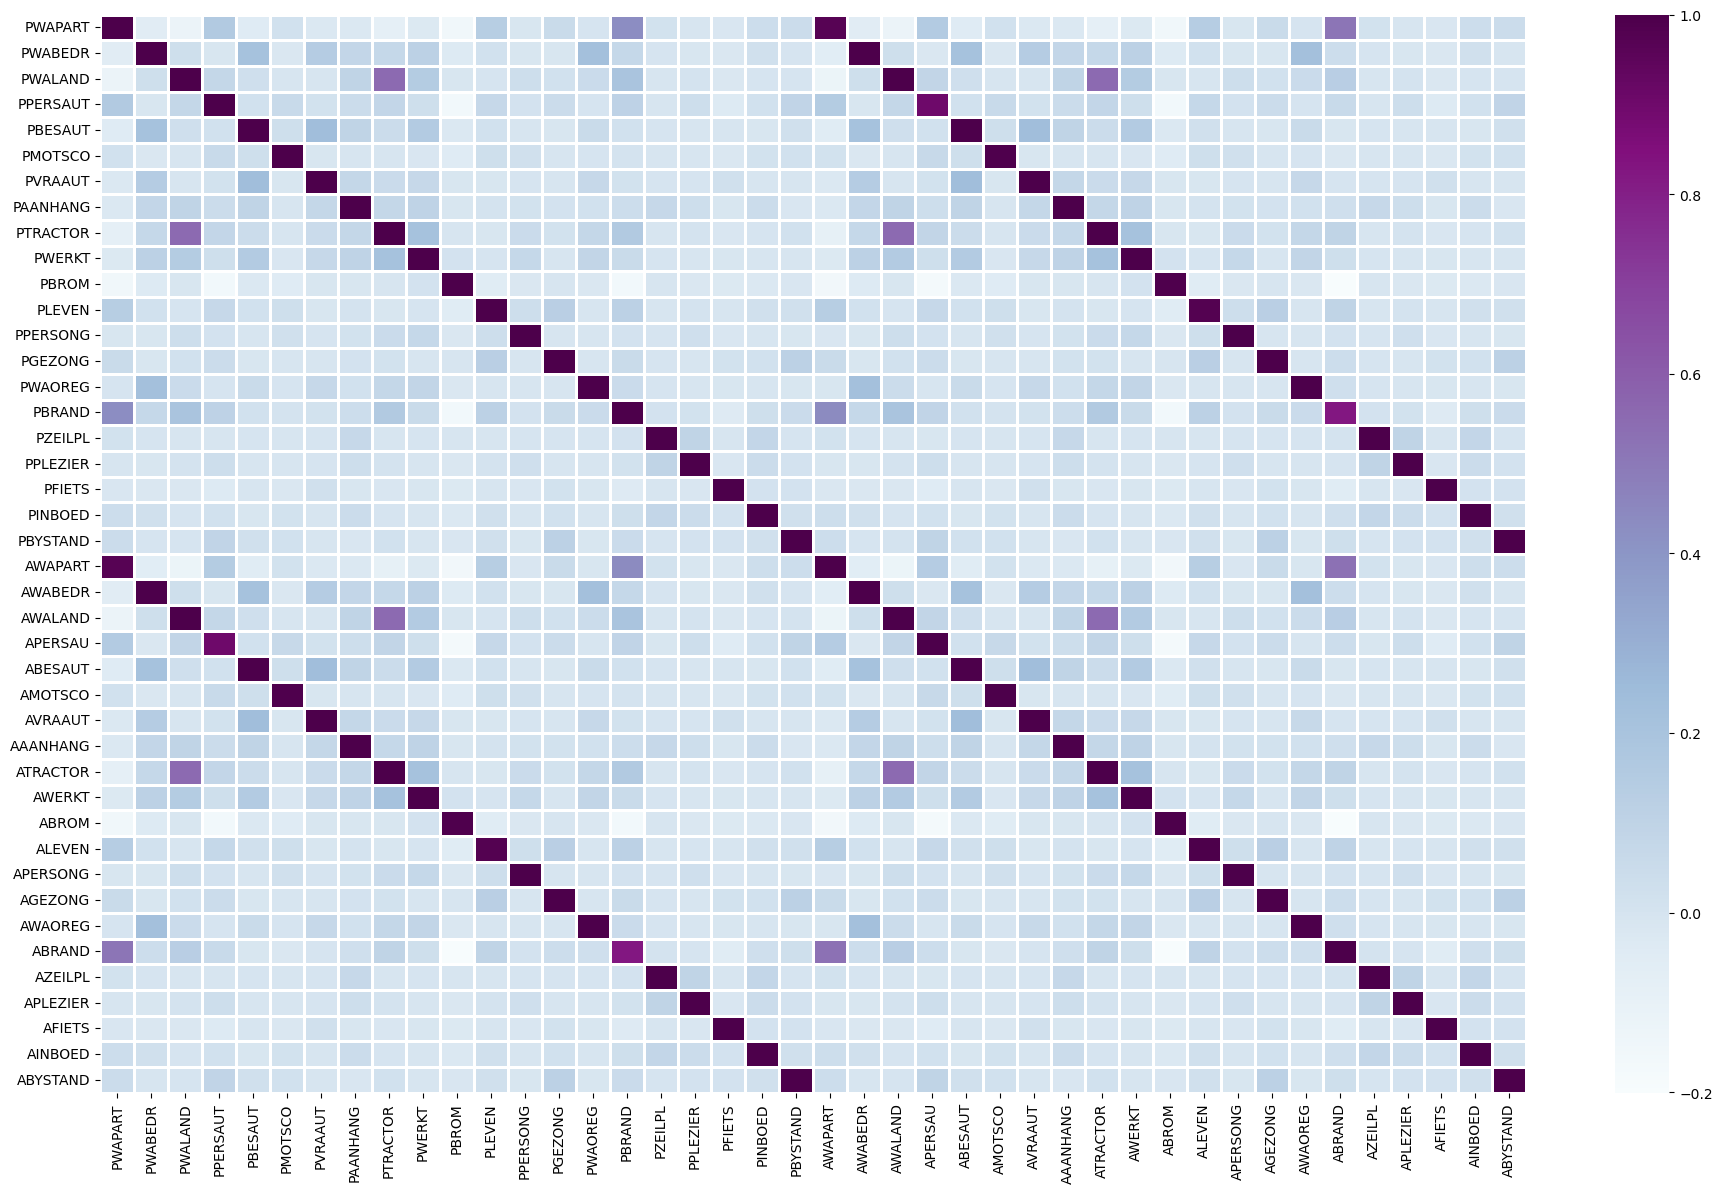

In [23]:
fig, ax = plt.subplots(figsize=(23, 14))
ax.plot()
ax = sns.heatmap(kendall_matrix,linewidths=0.9,cmap="BuPu",xticklabels=categoricas_vs_numericas.columns, yticklabels=categoricas_vs_numericas.columns)


Como estas parejas de variables están aportando información muy similar, optamos por eliminar aquellas de tipo categórico (las de escala L4 en el diccionario)

In [24]:
excluidas = ['PWAPART', 'PWABEDR', 'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO',
       'PVRAAUT', 'PAANHANG', 'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN',
       'PPERSONG', 'PGEZONG', 'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER',
       'PFIETS', 'PINBOED', 'PBYSTAND']

In [25]:
train_data = train_data.loc[:,~train_data.columns.isin(excluidas)]

## Análisis de las variables categóricas

Filtramos las variables categóricas restantes

In [26]:
filtro = ['MOSTYPE', 'MGEMLEEF', 'MOSHOOFD', 'MGODRK', 'MGODPR', 'MGODOV',
       'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV', 'MFALLEEN', 'MFGEKIND',
       'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG', 'MBERZELF',
       'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA', 'MSKB1',
       'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2', 'MAUT0',
       'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045', 'MINK4575', 'MINK7512',
       'MINK123M', 'MINKGEM', 'MKOOPKLA']

In [27]:
categorical_data = train_data[filtro]

Para evaluar el grado de asociación entre dichas variables, utilizamos la medida V de Cramer. Para cada pareja de variables calculamos dicha medida y la almacenamos en una matriz.

In [28]:
cramer_matrix = np.zeros((len(categorical_data.columns),len(categorical_data.columns)))

for i in range(0,len(categorical_data.columns)):
    for j in range(0,len(categorical_data.columns)):
        cramer_matrix[i,j]=cramers_v(categorical_data.iloc[:,i],categorical_data.iloc[:,j])

Representamos la matriz mediante un heatmap.

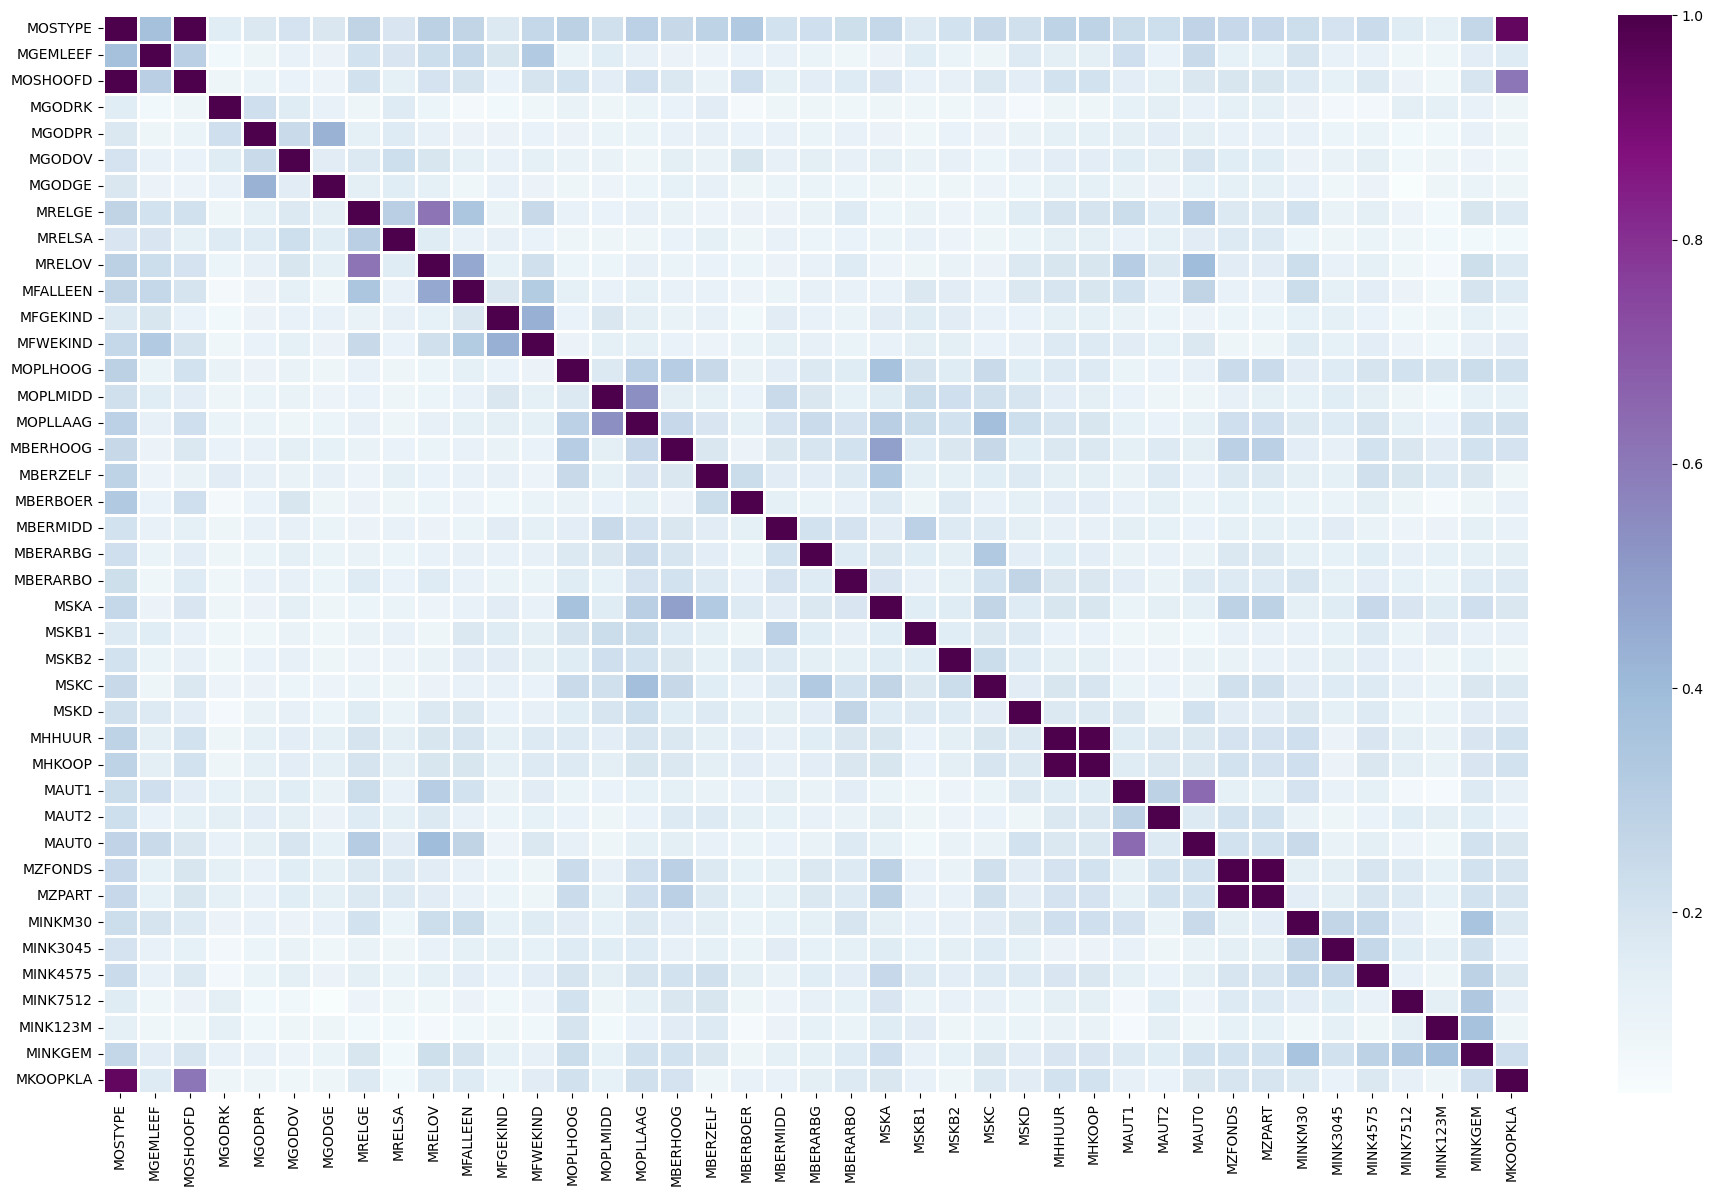

In [29]:
fig, ax = plt.subplots(figsize=(23, 14))
ax.plot()
ax = sns.heatmap(cramer_matrix,linewidths=0.9,cmap="BuPu",xticklabels=categorical_data.columns, yticklabels=categorical_data.columns)

Aparecen variables cuyo grado de asociación es muy elevado. Estas variables estarían ofreciendo una información muy similar, por lo que optamos por prescindir de una de las dos. En primer lugar, creamos una lista en la que se incluyen estos pares de variables categóricas con un grado de asociación muy alto entre ellas.

In [30]:
variables_similares=[]
for i in range(0,len(categorical_data.columns)):
    for j in range(i+1,len(categorical_data.columns)):
        if cramer_matrix[i,j]>0.9:
            variables_similares.append((categorical_data.columns[i],categorical_data.columns[j]))
            

In [31]:
print(variables_similares)

[('MOSTYPE', 'MOSHOOFD'), ('MOSTYPE', 'MKOOPKLA'), ('MHHUUR', 'MHKOOP'), ('MZFONDS', 'MZPART')]


Para decidir con que variable quedarnos, nos hemos apoyado en la distribución de frecuencias de los datos de cada una de ellas.

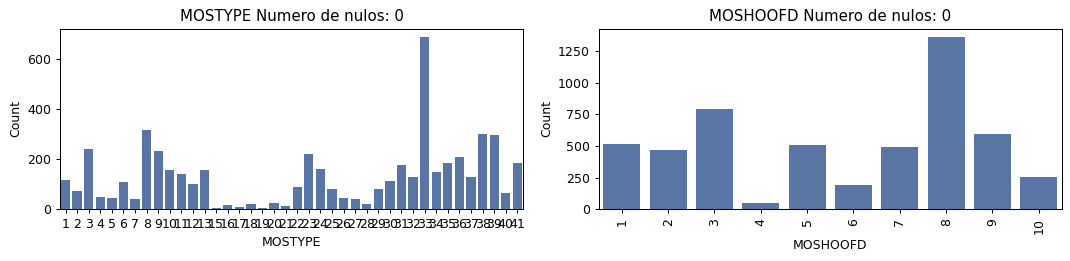

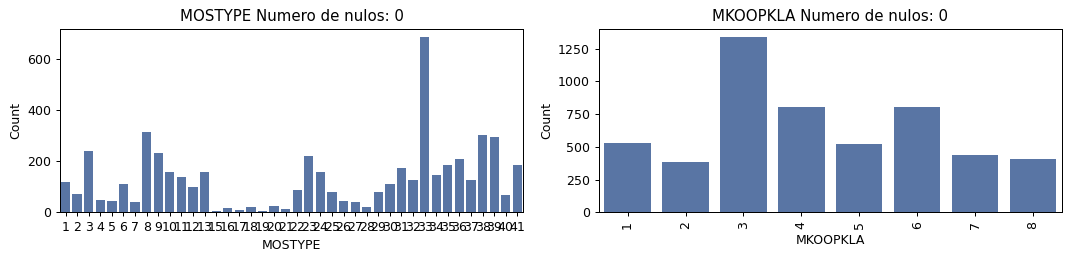

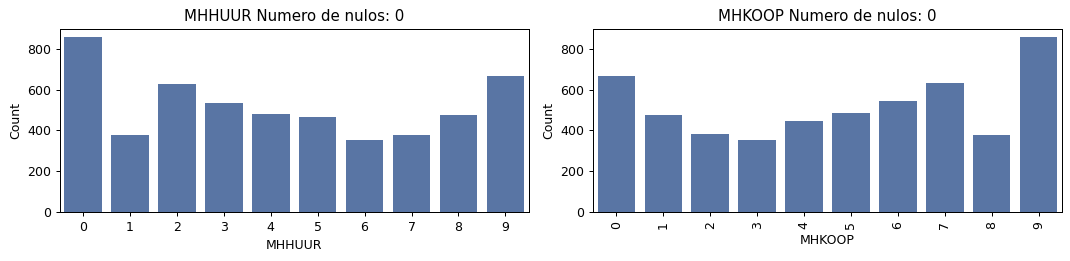

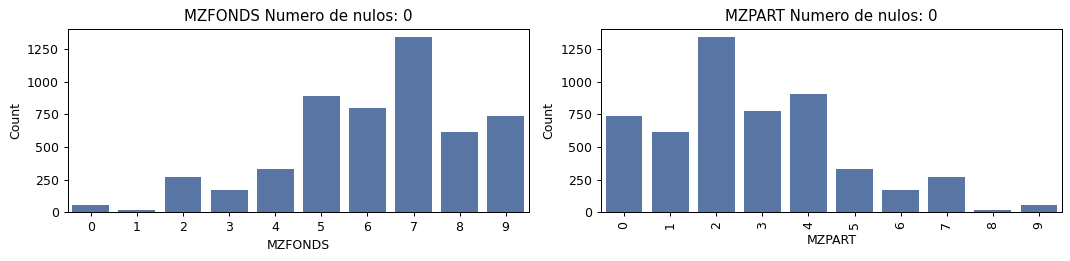

In [32]:
warnings.filterwarnings('ignore')
for pareja in list(variables_similares):
        plot_feature2(train_data, col_name=pareja[0], col_name2=pareja[1])

Dado que la asociación entre MOSTYPE con MOSHOOFD y MKOOPKLA es muy eleveda, optamos por prescindir de las dos últimas, que también tenían un grado de asoción elevado entre ellas, entorno a 0.60.
Las variables MHHUUR y MHKOOP, y MZFONDS y MZPART son simétricas en cuanto a sus frecuencias por lo que las consideramos como duplicados. De esta forma omitiremos las variables MHKOOP y MZPART.

In [33]:
excluidas = ['MOSHOOFD', 'MKOOPKLA', 'MHKOOP', ' MZPART']

In [34]:
categorical_data = categorical_data.loc[:,~categorical_data.columns.isin(excluidas)]
train_data = train_data.loc[:,~train_data.columns.isin(excluidas)]

## Análisis de las variables numéricas

Filtramos las variables numéricas

In [35]:
numeric_data = train_data.loc[:,~train_data.columns.isin(list(categorical_data.columns))]

### Análisis de outliers

Tras el siguiente análisis, decidimos dejarlos sin sustituir. Una vez se llegara al modelo se podrían realizar reemplazamientos de estos outliers utilizando diferentes métodos para comprobar si el modelo obtiene mejores resultados

In [36]:
numeric_data.columns

Index(['MAANTHUI', 'MGEMOMV', 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAU',
       'ABESAUT', 'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT',
       'ABROM', 'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND',
       'AZEILPL', 'APLEZIER', 'AFIETS', 'AINBOED', 'ABYSTAND', 'CARAVAN'],
      dtype='object')

In [37]:
outliers = get_deviation_of_mean_perc(train_data, list(numeric_data.columns), target='CARAVAN', multiplier=3)
outliers.iloc[:,[1,2,3,0,4]]

variable  sum_outlier_values  porcentaje_sum_null_values         0  \
0   MAANTHUI                  44                    0.008429  1.000000   
1    AWAPART                   6                    0.001149  1.000000   
2    AWABEDR                  82                    0.015709  0.939024   
3    AWALAND                 120                    0.022989  0.975000   
4    APERSAU                  19                    0.003640  0.947368   
5    ABESAUT                  48                    0.009195  0.958333   
6    AMOTSCO                 220                    0.042146  0.927273   
7    AVRAAUT                   9                    0.001724  1.000000   
8   AAANHANG                  65                    0.012452  0.907692   
9   ATRACTOR                 143                    0.027395  0.965035   
10    AWERKT                  21                    0.004023  1.000000   
11     ABROM                 360                    0.068966  0.977778   
12    ALEVEN                 120                    0.022989  0.875000   
13  APERSONG                  31                    0.005939  0.967742   
14   AGEZONG                  38                    0.007280  0.842105   
15   AWAOREG                  23                    0.004406  0.826087   
16    ABRAND                  13                    0.002490  1.000000   
17   AZEILPL                   3                    0.000575  0.666667   
18  APLEZIER                  33                    0.006322  0.606061   
19    AFIETS                 145                    0.027778  0.896552   
20   AINBOED                  45                    0.008621  0.888889   
21  ABYSTAND                  82                    0.015709  0.804878   
22   CARAVAN                 340                    0.065134  1.000000   

           1  
0        NaN  
1        NaN  
2   0.060976  
3   0.025000  
4   0.052632  
5   0.041667  
6   0.072727  
7        NaN  
8   0.092308  
9   0.034965  
10       NaN  
11  0.022222  
12  0.125000  
13  0.032258  
14  0.157895  
15  0.173913  
16       NaN  
17  0.333333  
18  0.393939  
19  0.103448  
20  0.111111  
21  0.195122  
22       NaN

Se puede observar que algunas de las variables como 'APLEZIER' o 'AZEILPL' se ven afectadas en aquellos individuos considerados outliers dado que la distribución en cuanto al target difiere de la propoción 93.5 - 6.5, en favor de aquellos que si contratan póliza de caravanas.

Realizamos el análisis de correlación de Pearson de estas variables (excluyendo el target) y representamos su correpondiente matriz

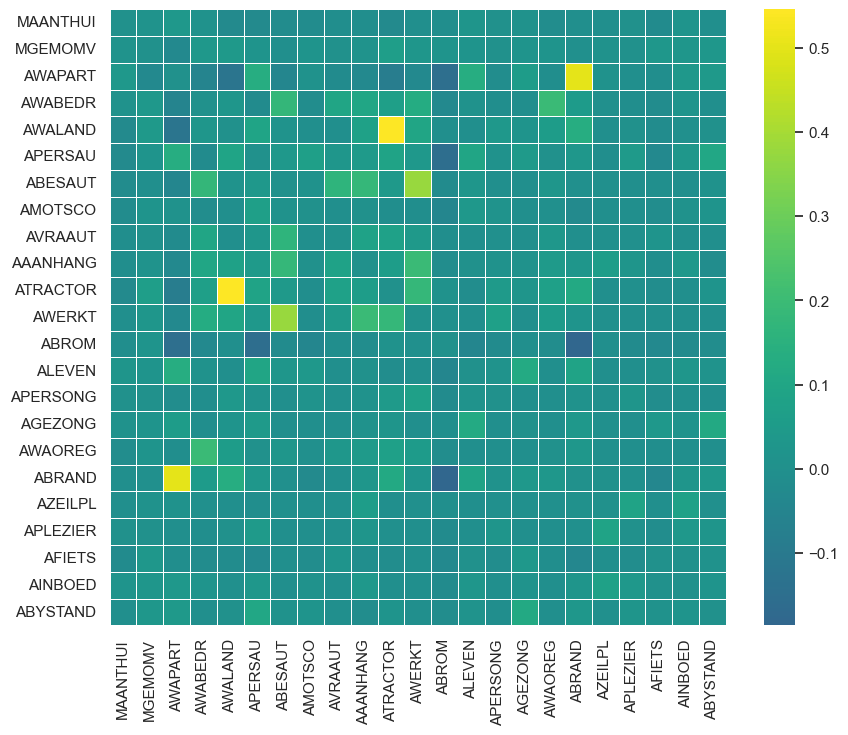

In [38]:
get_corr_matrix(dataset = numeric_data.loc[:,~numeric_data.columns.isin(['CARAVAN'])], 
                metodo='pearson', size_figure=[10,8])

Como las correlaciones no son tan elevadas, no prescindimos de ninguna de las variables numéricas

## Representación gráfica

Representamos gráficamente únicamente las variables escogidas 

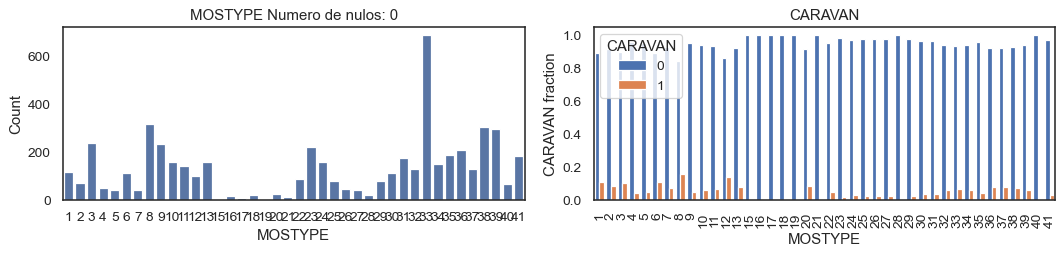

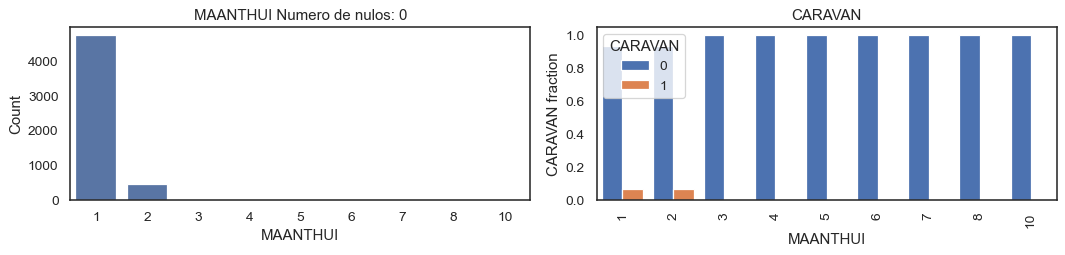

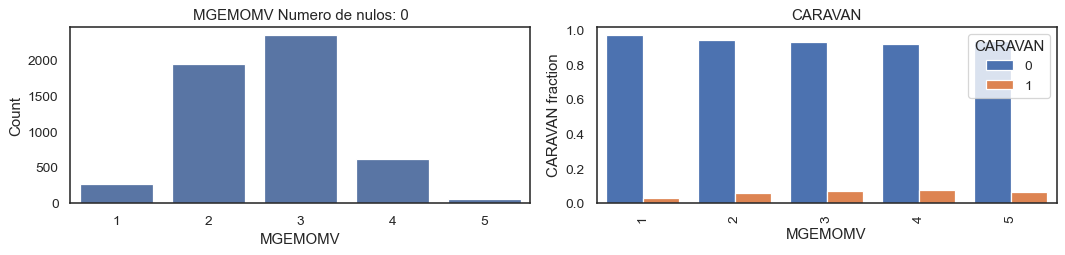

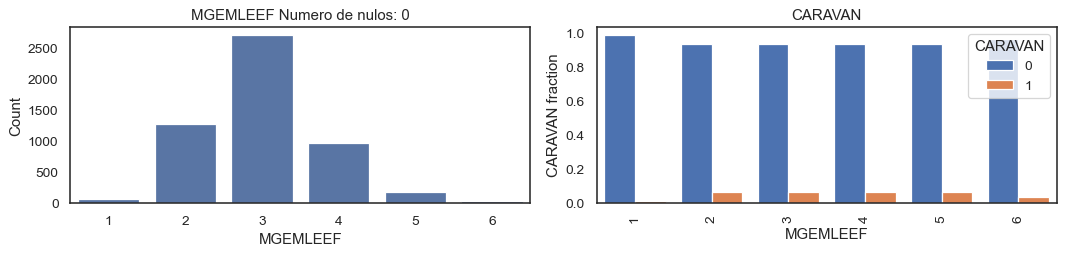

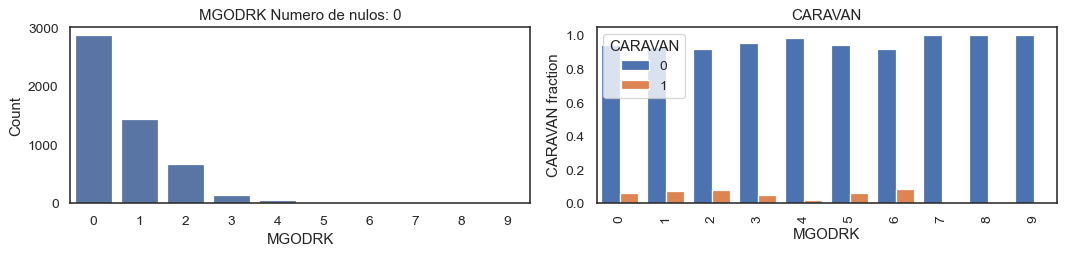

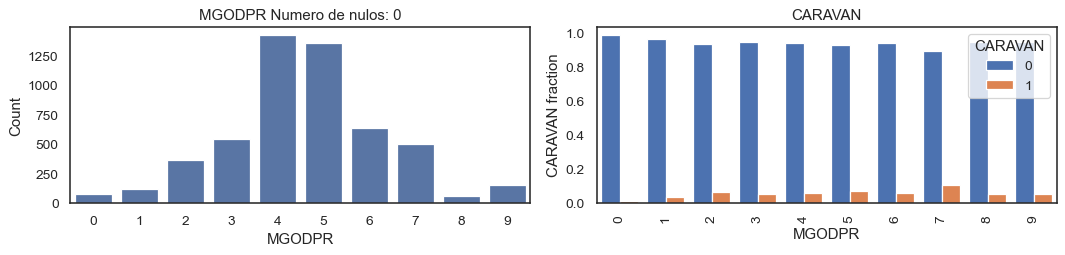

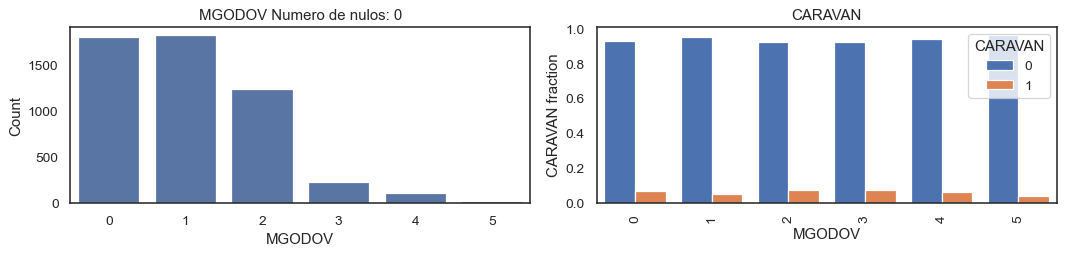

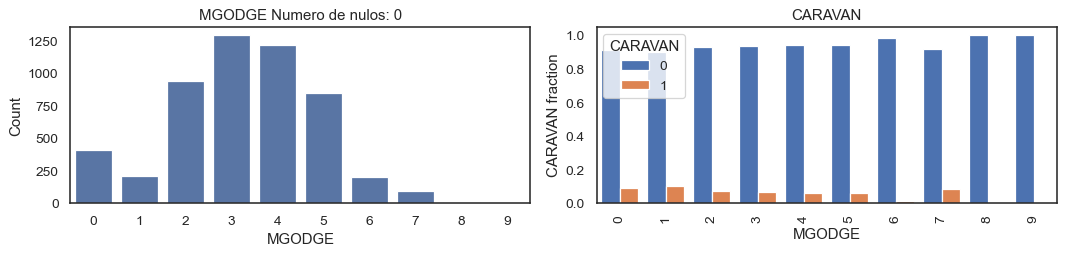

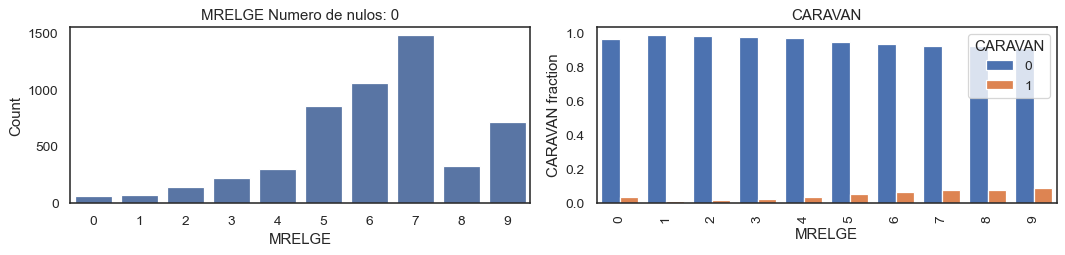

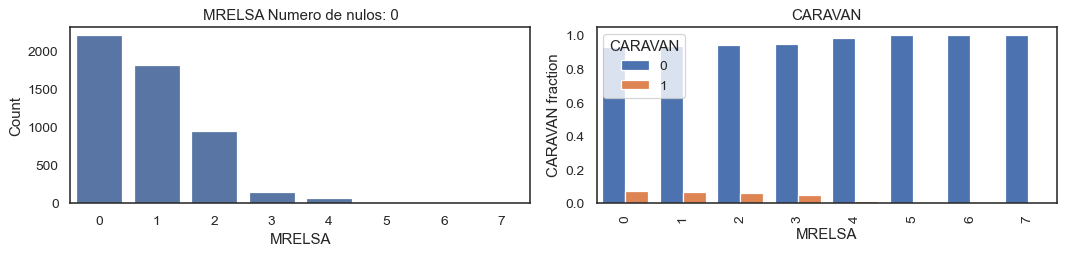

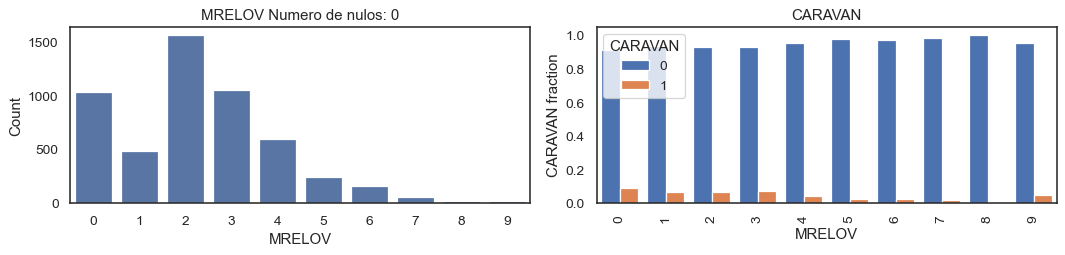

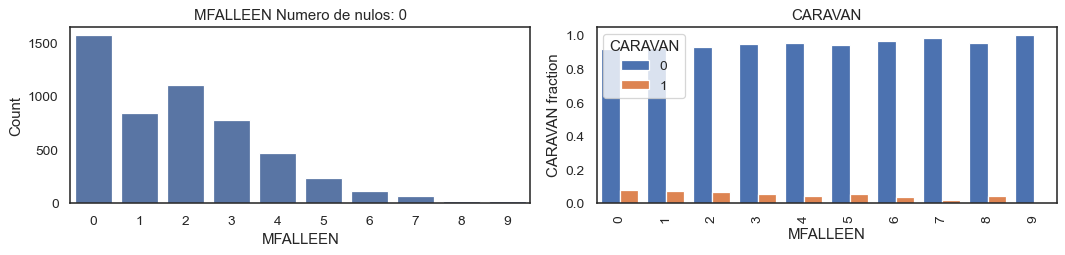

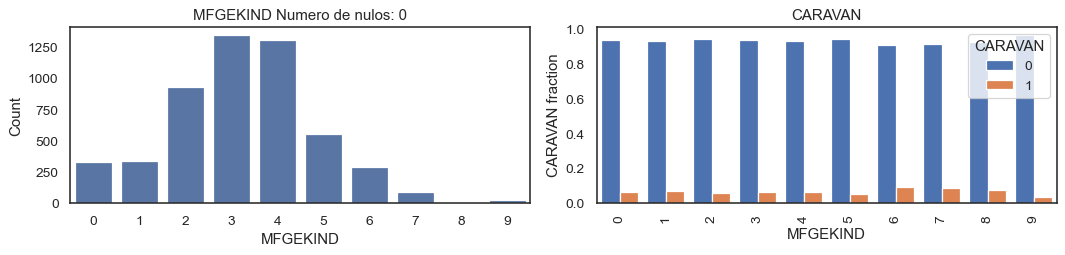

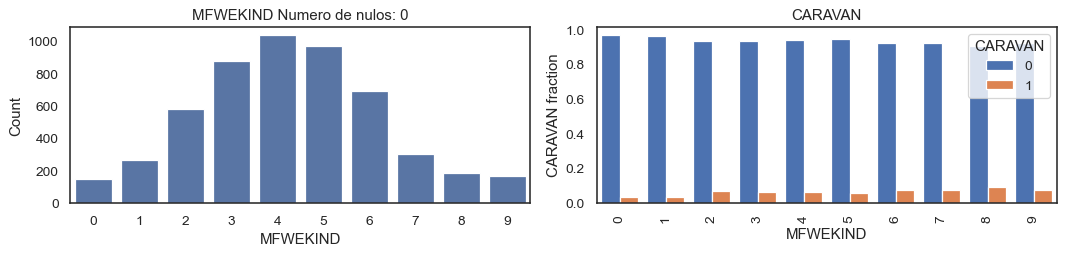

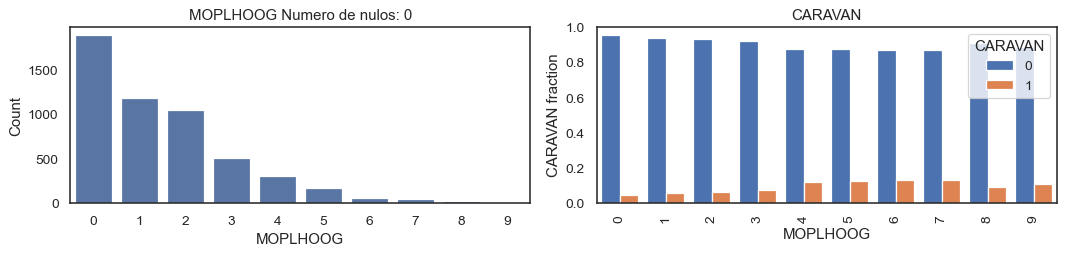

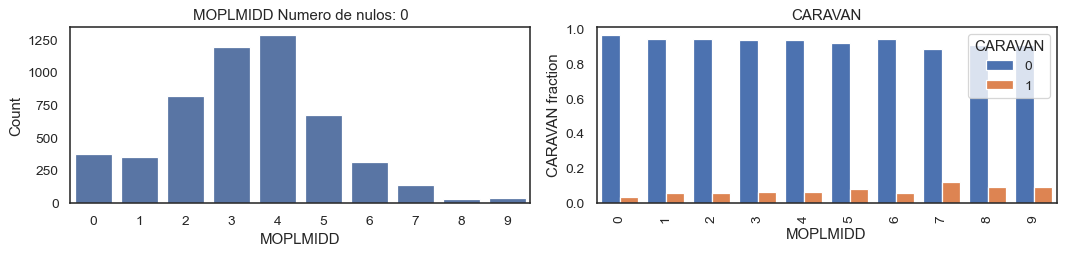

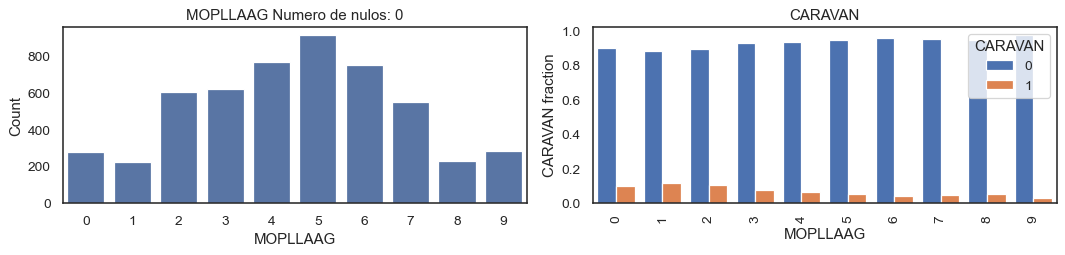

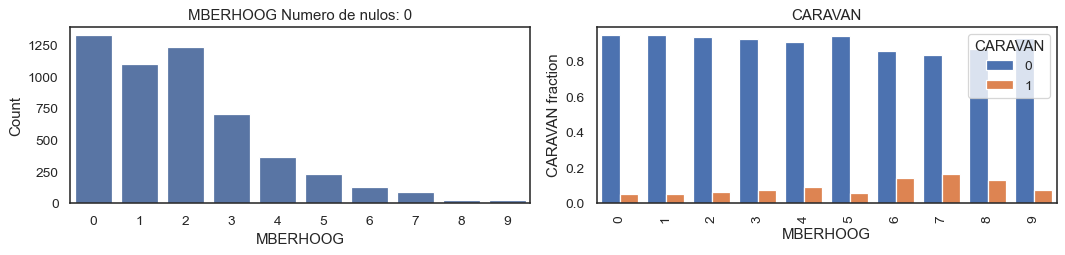

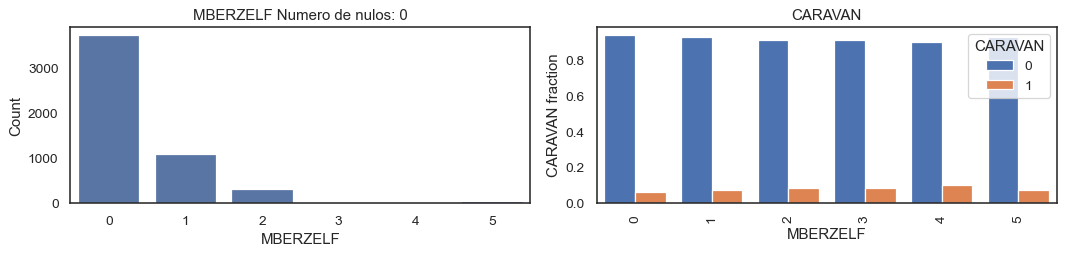

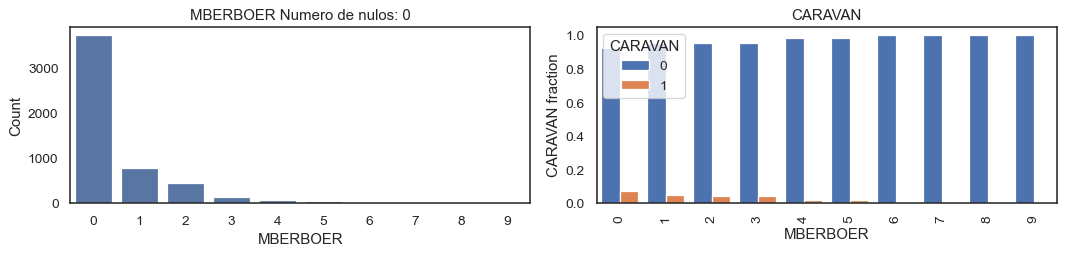

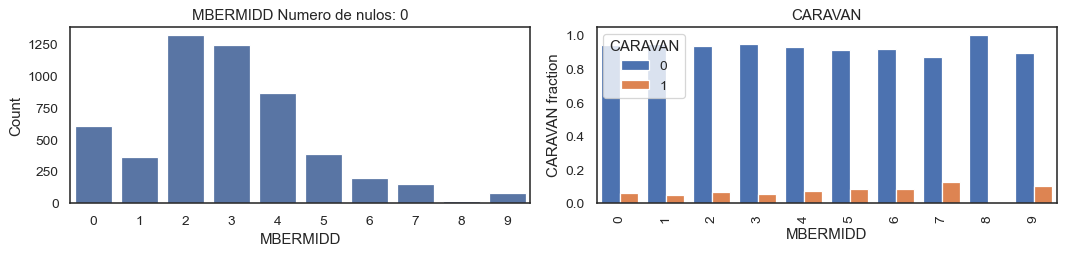

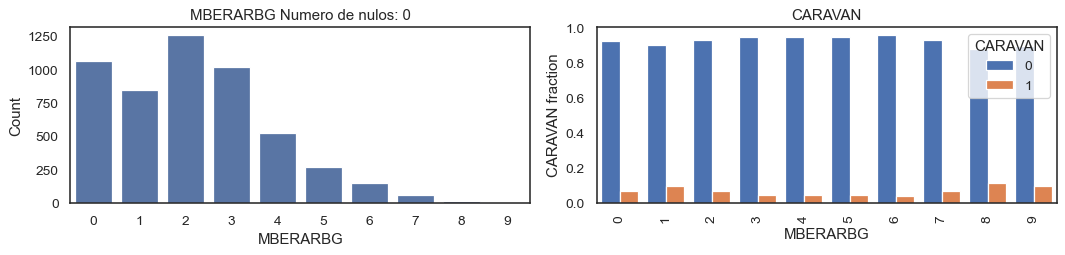

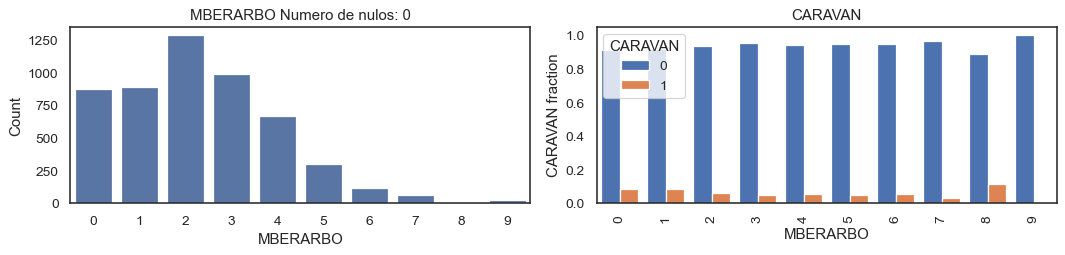

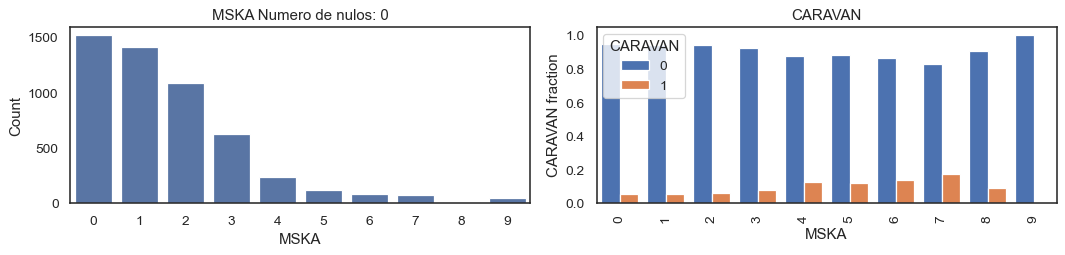

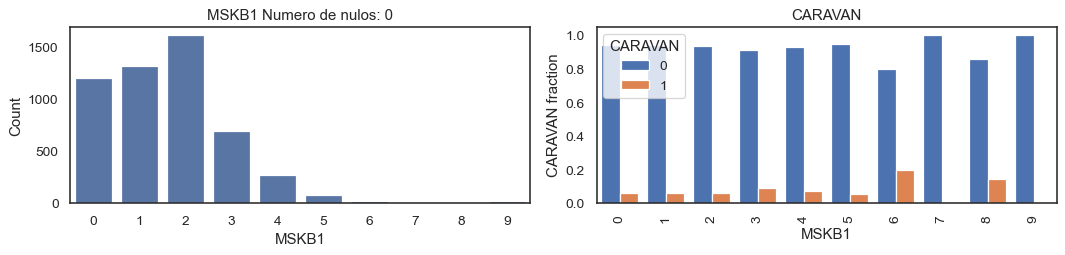

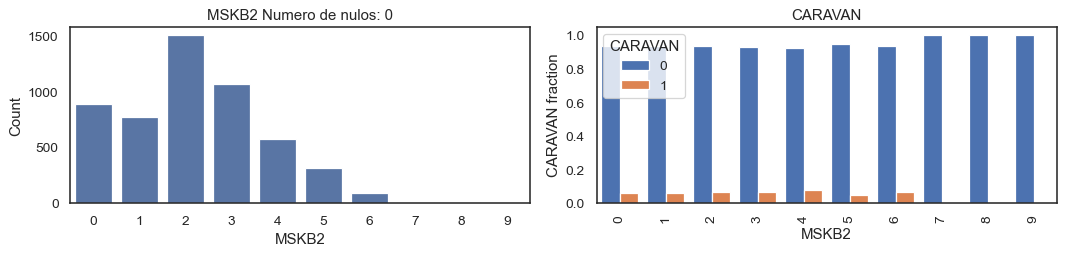

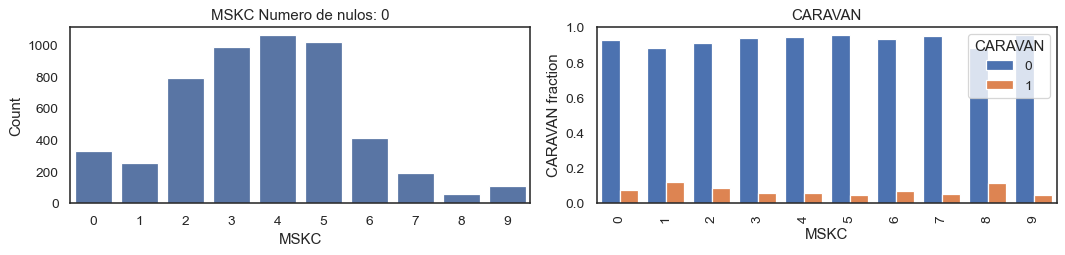

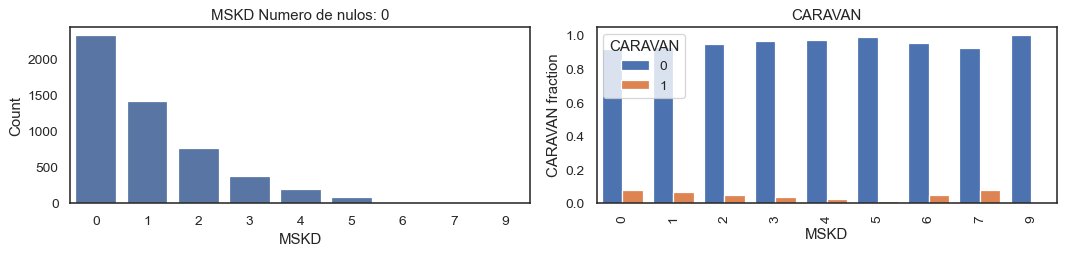

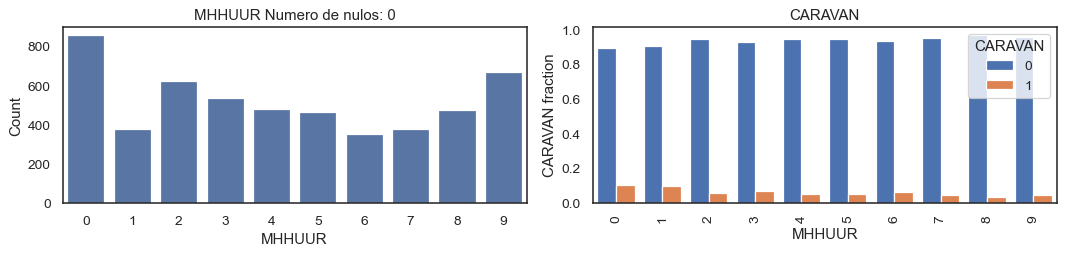

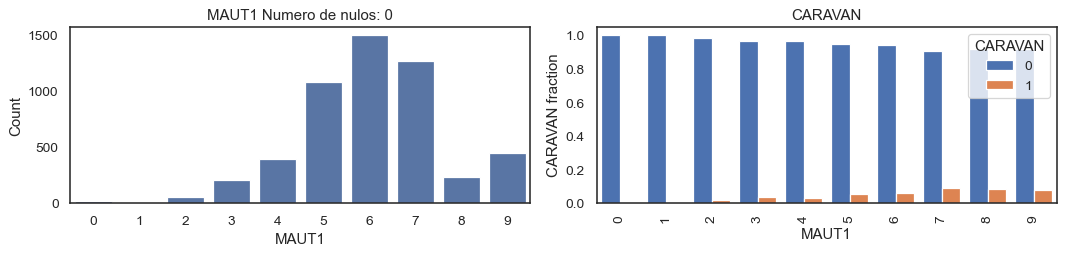

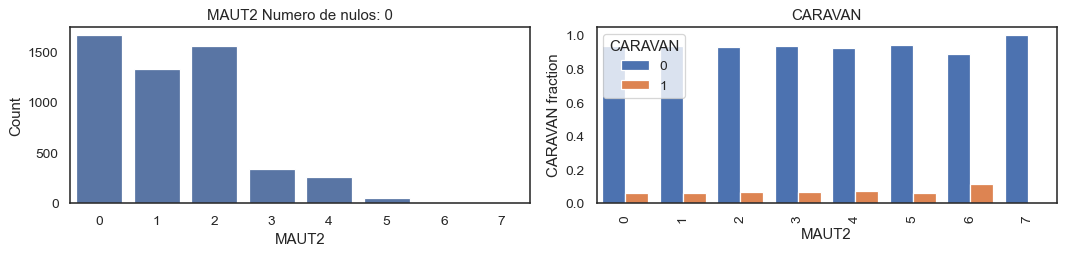

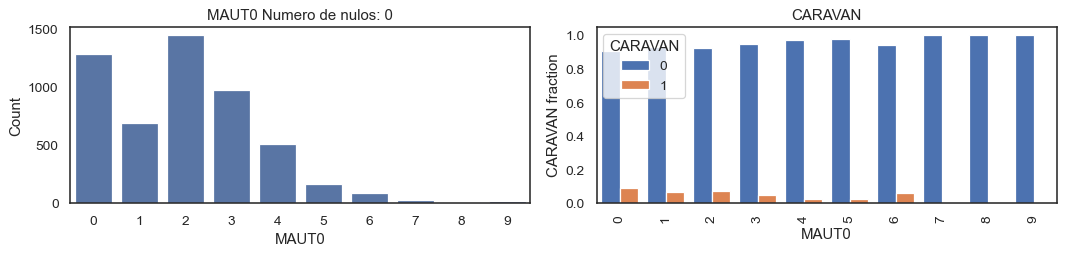

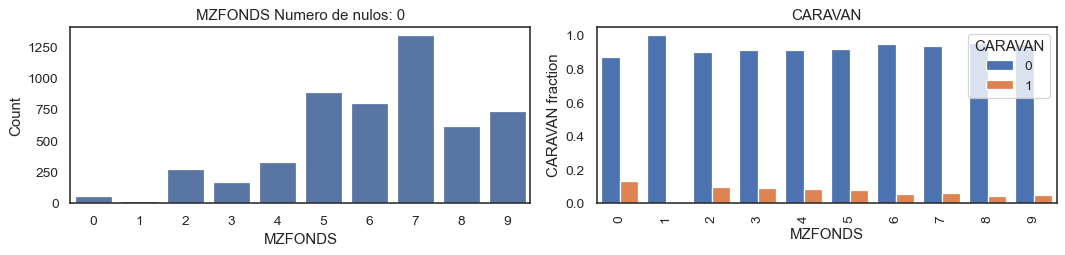

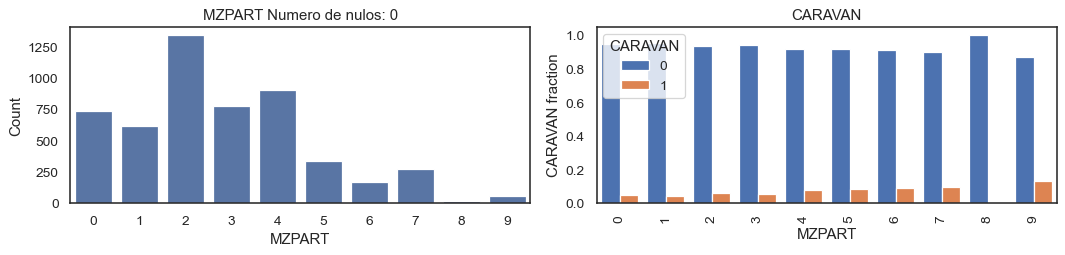

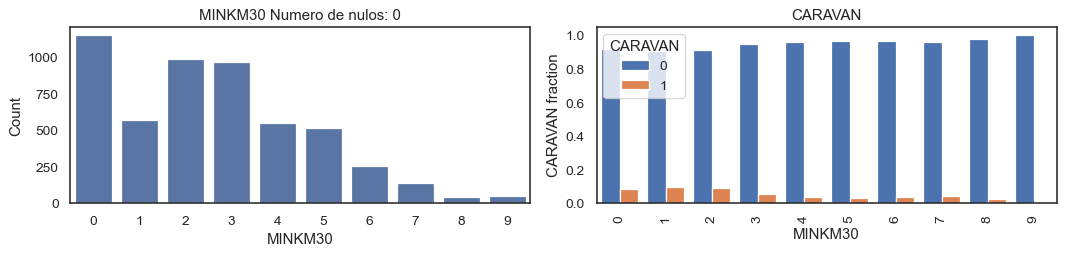

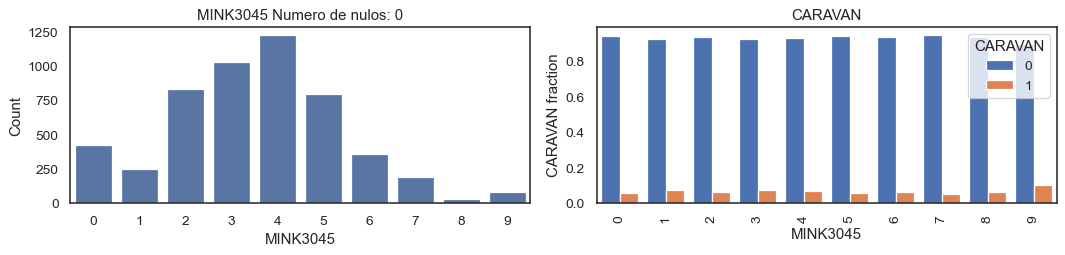

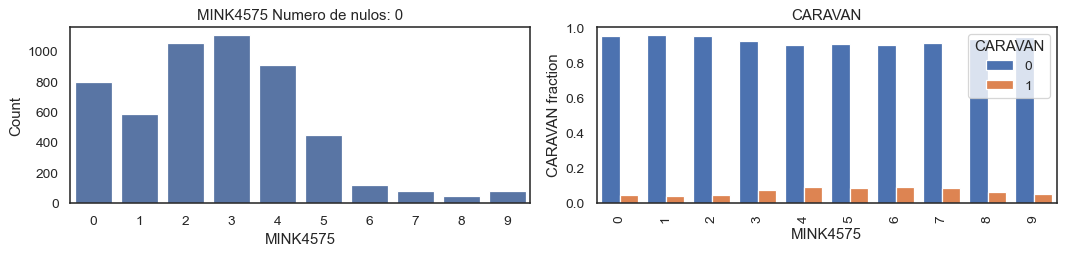

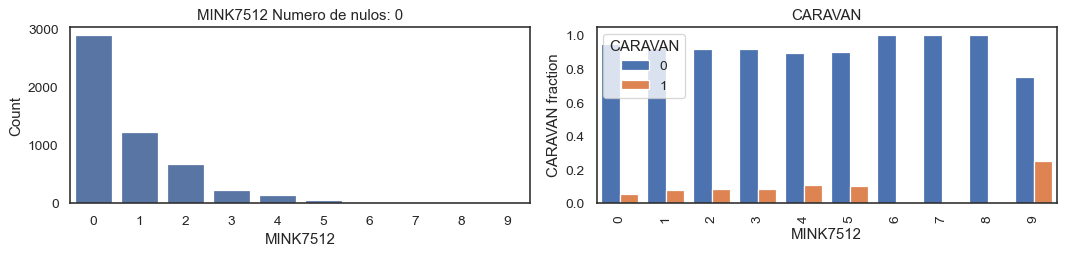

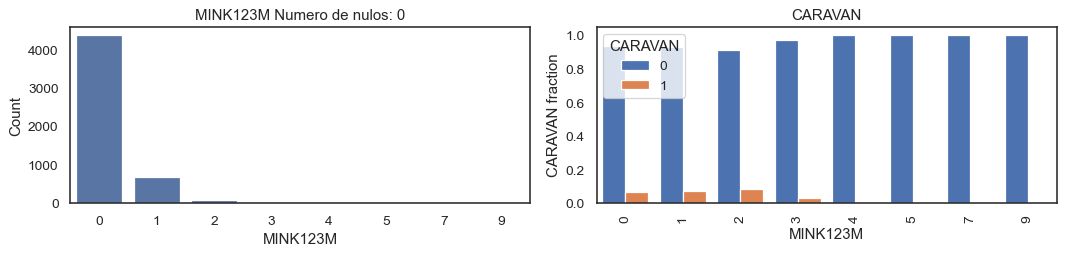

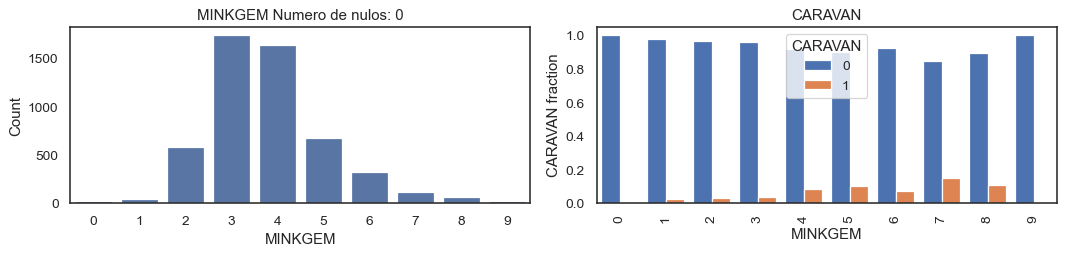

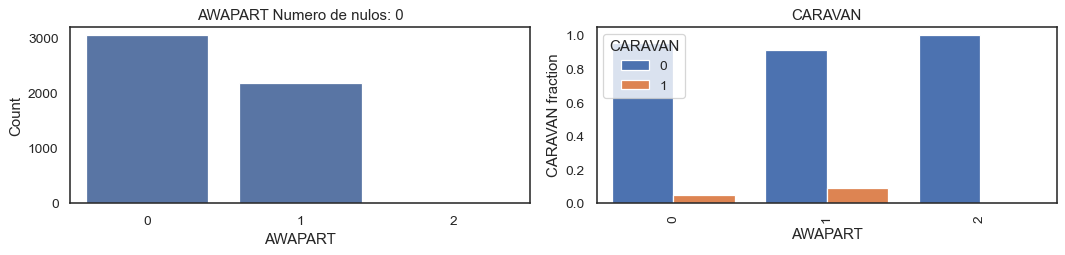

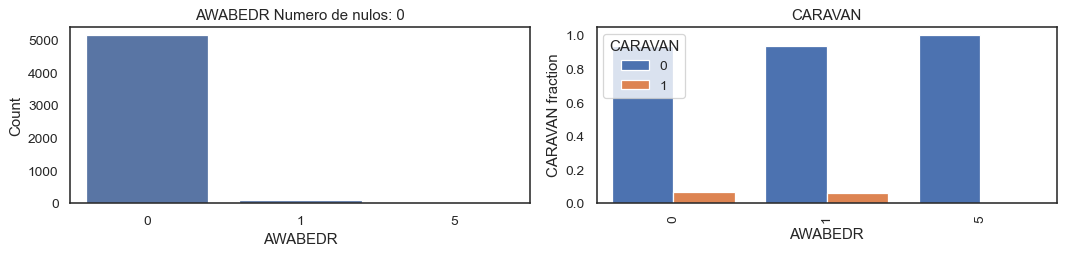

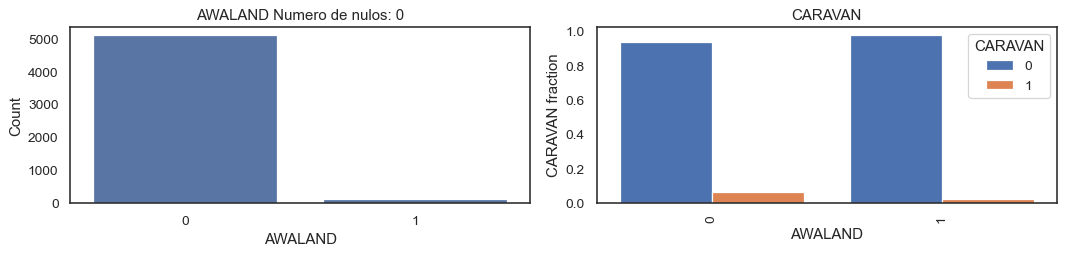

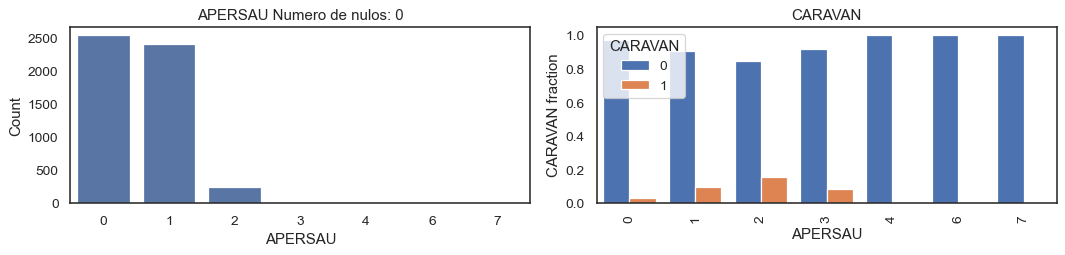

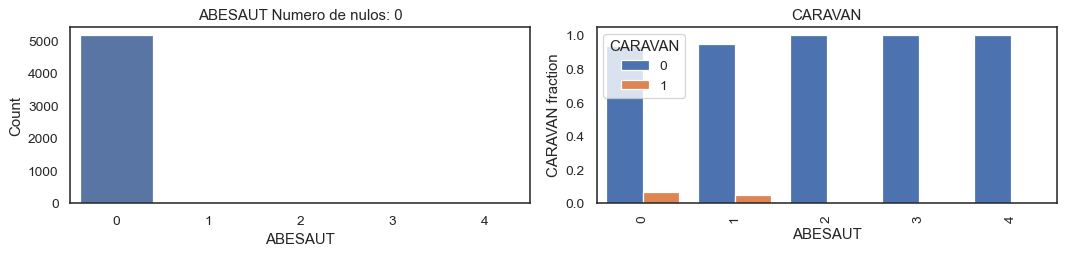

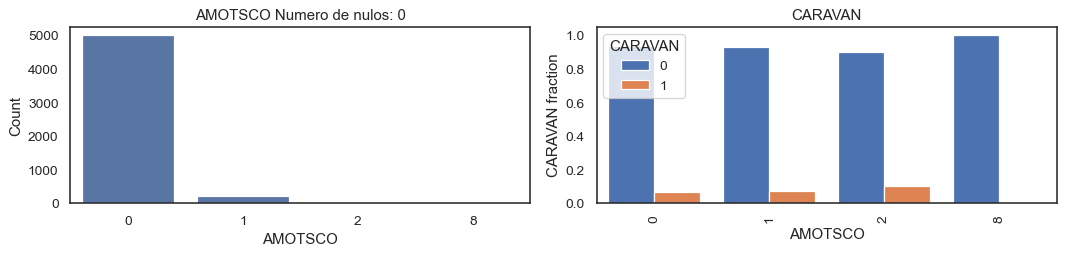

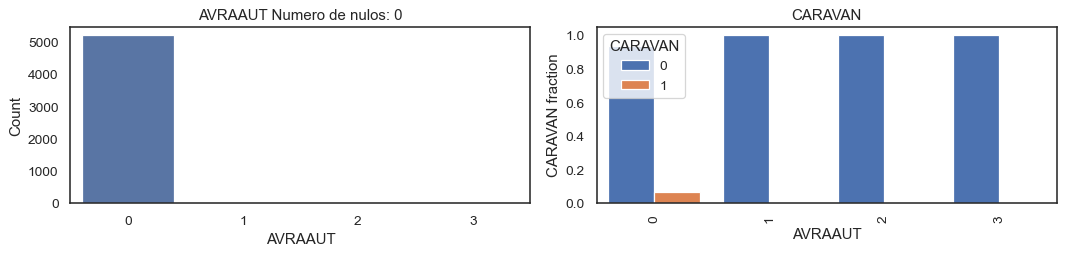

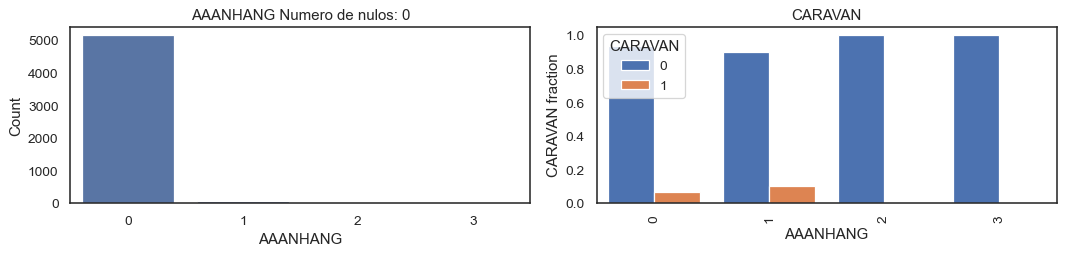

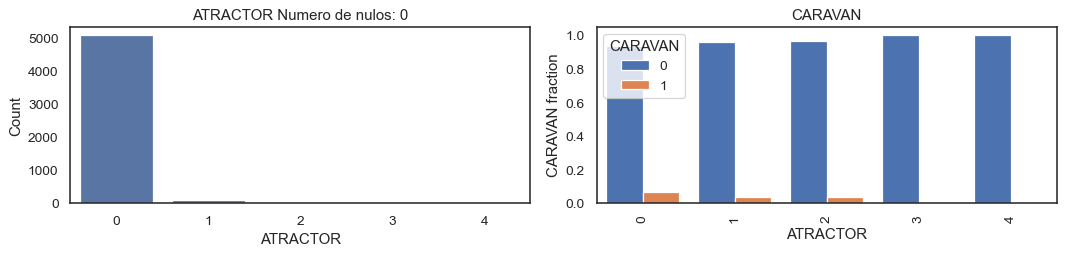

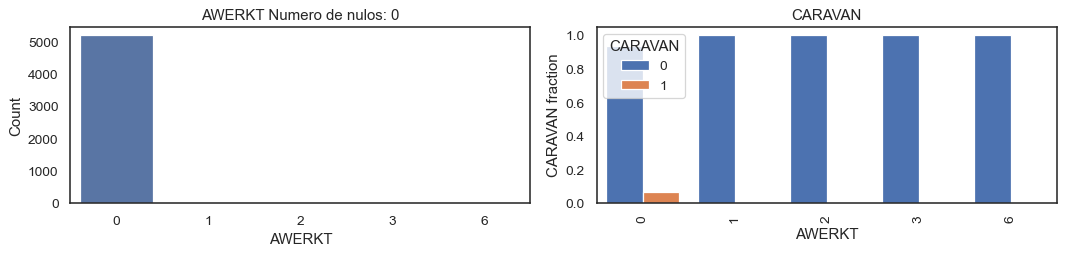

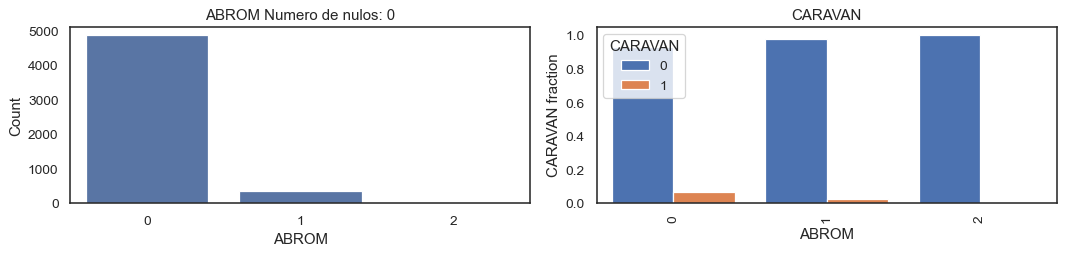

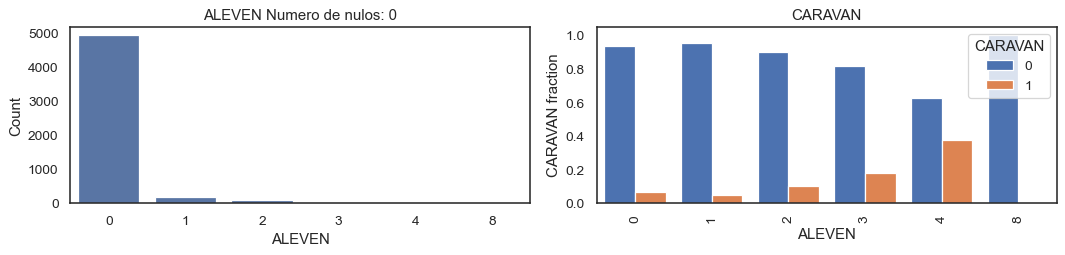

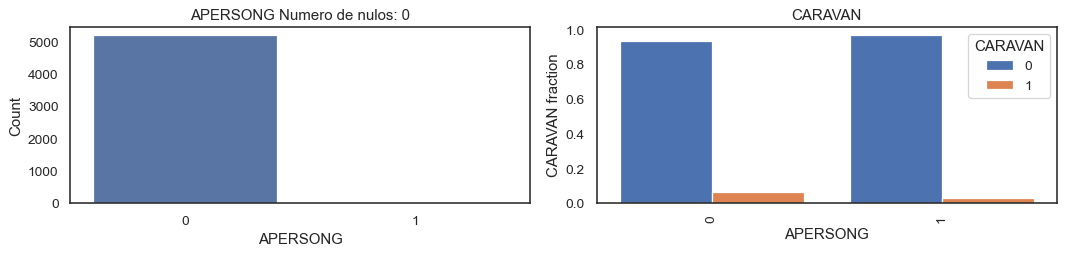

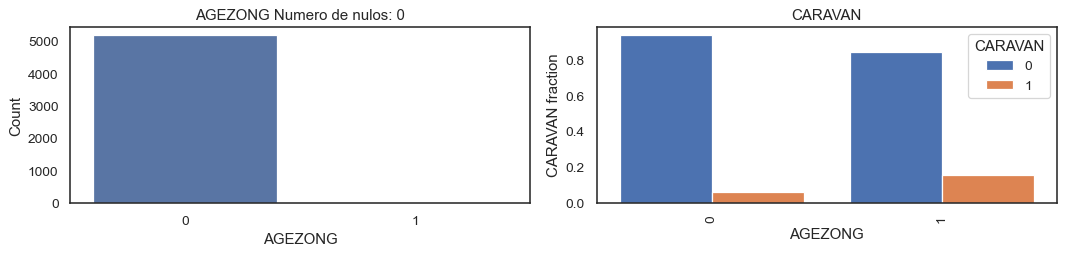

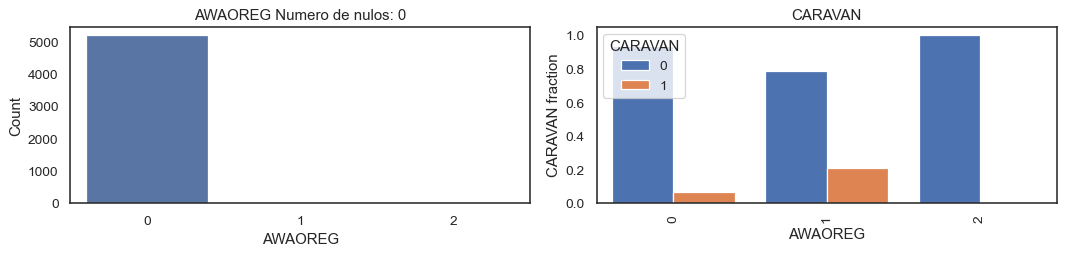

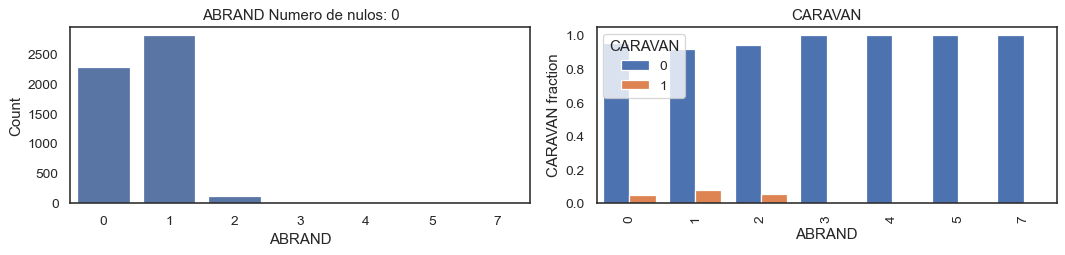

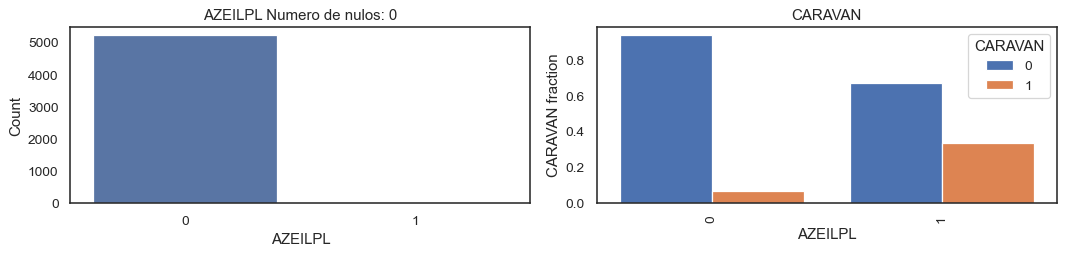

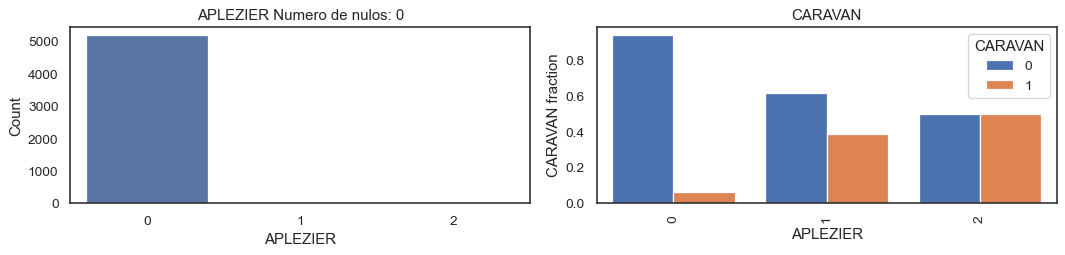

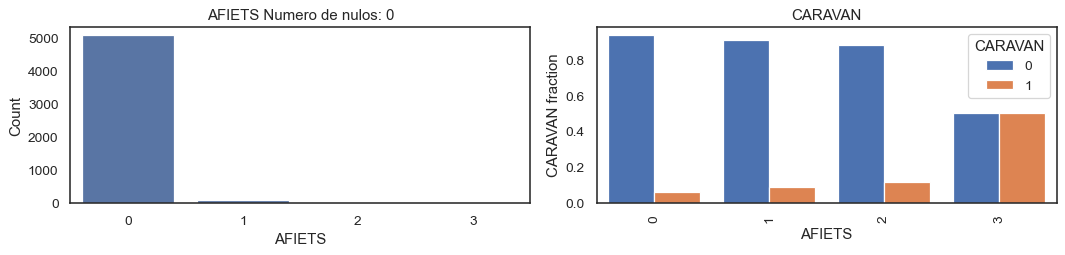

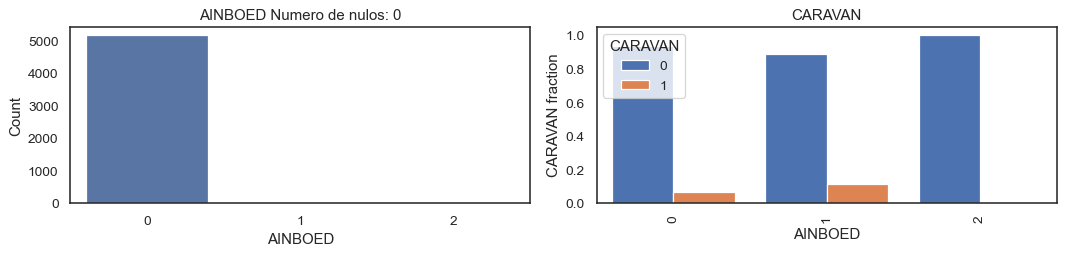

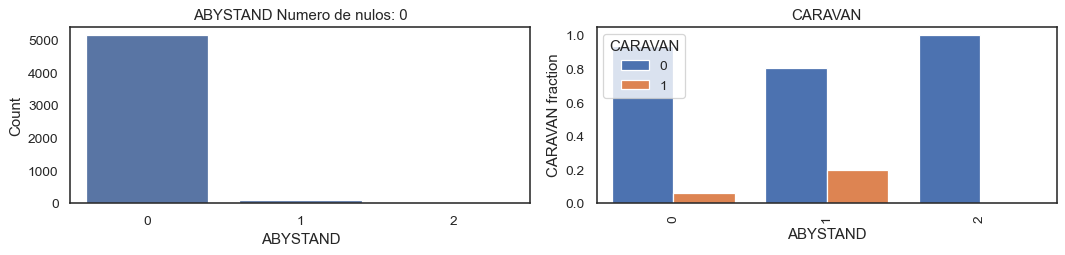

In [39]:
warnings.filterwarnings('ignore')
for i in list(train_data.loc[:,~train_data.columns.isin(['CARAVAN'])]):
        plot_feature(train_data, col_name=i, target='CARAVAN')

Para la mayoría de variables la categoría o valor más repetido (moda para el caso de las variables categóricas) está más relaciona con aquellos individuos que no contraron póliza de caravanas; sin embargo, para algunas de estas variables, las categorías o valores con menor frecuencia obtienen una implicación mayor con la contratación de carvanas ('MINK7512', 'AFIETS', 'APLEZIERS', ...)

Además, se puede observar que muchas de las variables categóricas están desbalanceadas. Por ello, decidimos agrupar ciertas categorías que no presenten frecuencias elevadas

In [40]:
desbalanceadas = []
for i in list(categorical_data.columns):
    for j in categorical_data[i].value_counts().index:
        categorical_data[i].value_counts().sum()
        if categorical_data[i].value_counts()[j]/categorical_data[i].value_counts().sum()>0.70:
            desbalanceadas.append(i)
            break

In [41]:
desbalanceadas

['MBERZELF', 'MBERBOER', 'MINK123M']

In [42]:
data_grouped = categorical_data.copy()
for i in list(data_grouped.columns):
    total = data_grouped[i].value_counts().sum()
    categoria=[]
    for j in data_grouped[i].value_counts().index:
        if data_grouped[i].value_counts()[j]/total<0.05:
            categoria.append(j)
    if len(categoria)>1:
        data_grouped[i] = np.where(data_grouped[i].isin(categoria), 99, data_grouped[i])

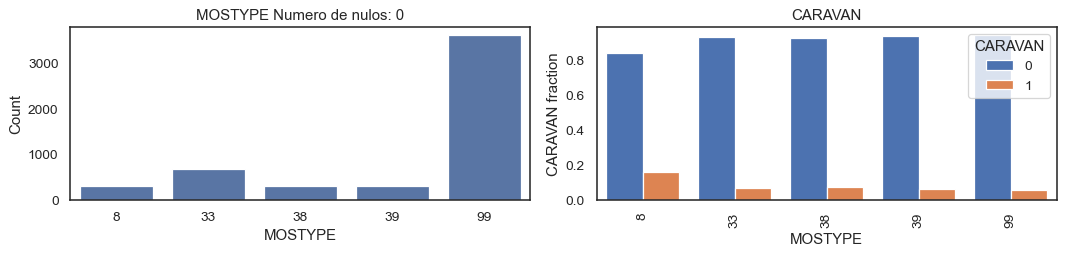

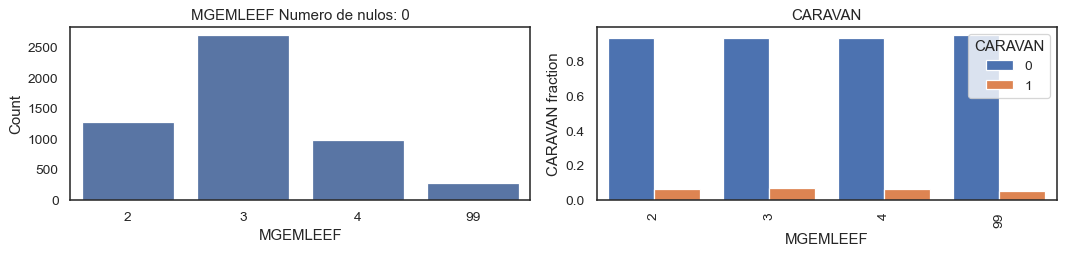

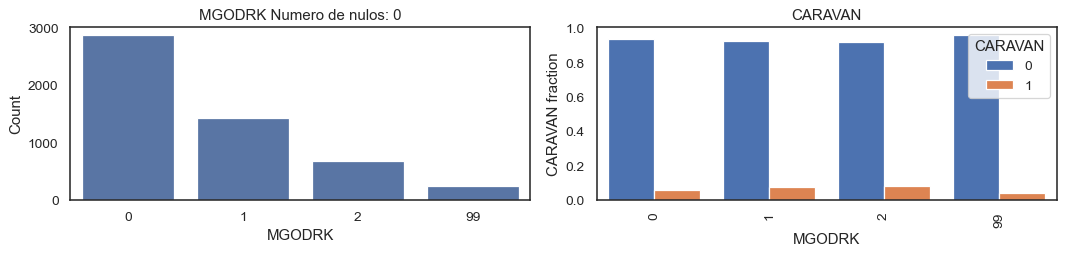

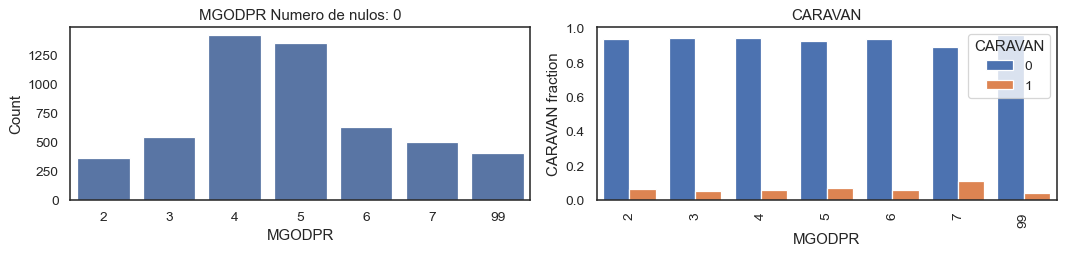

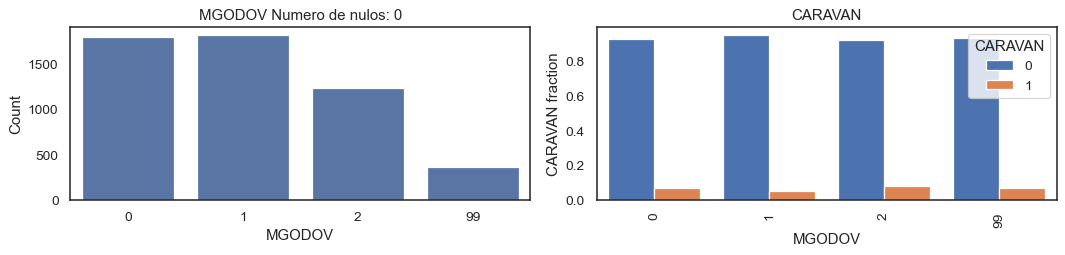

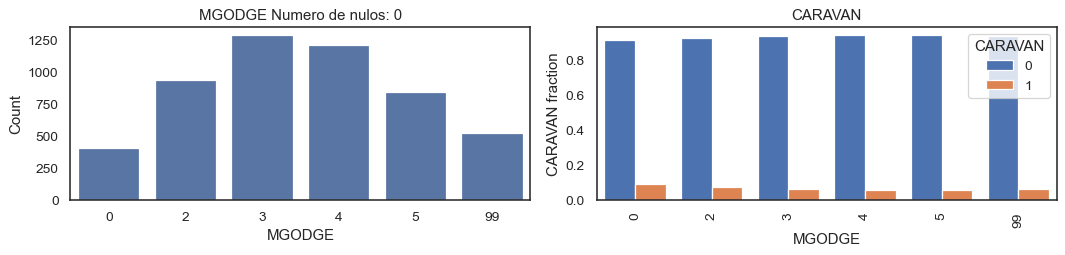

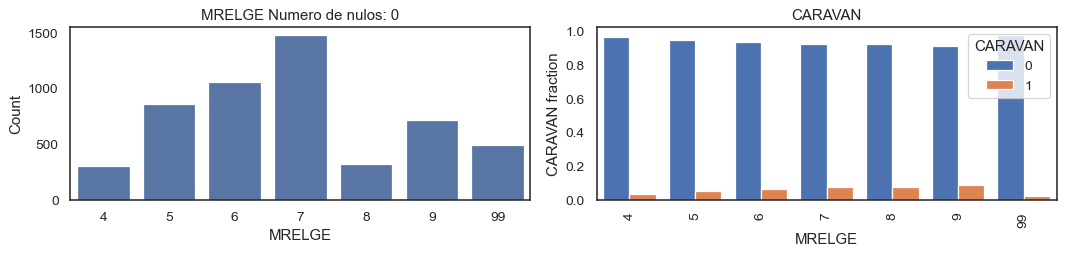

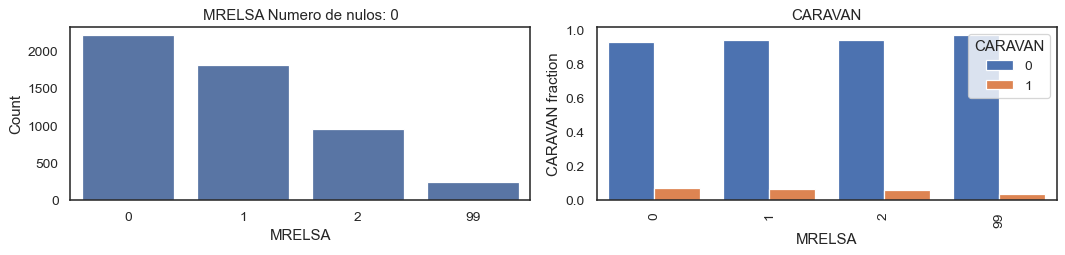

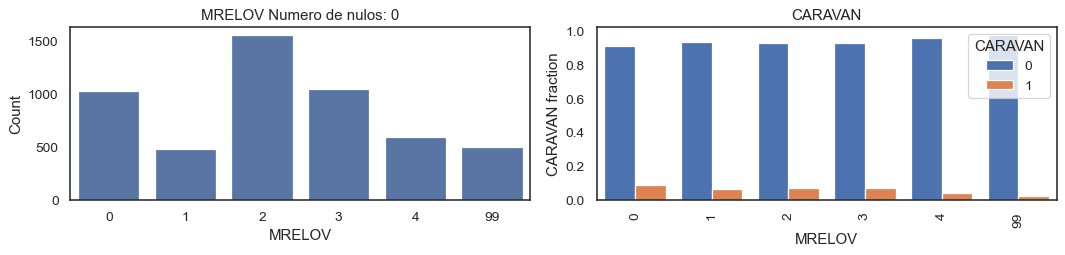

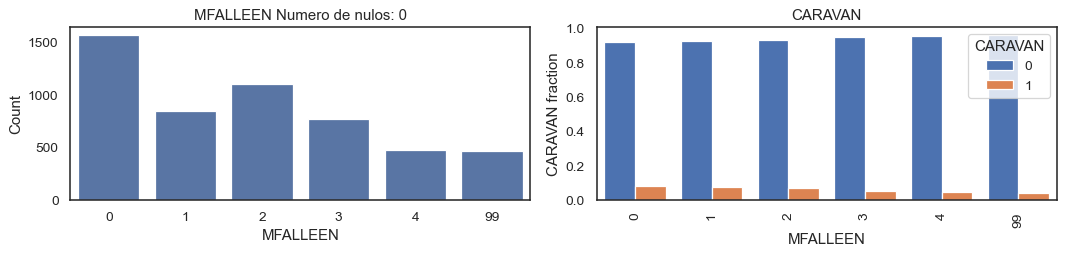

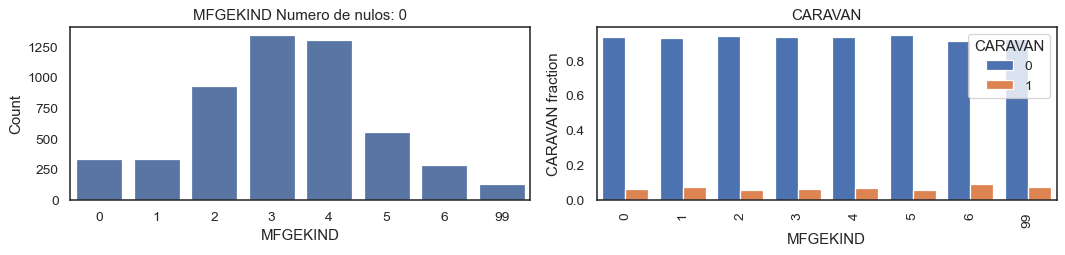

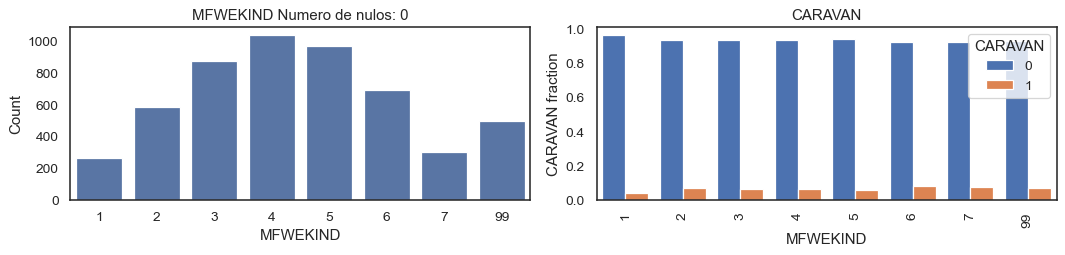

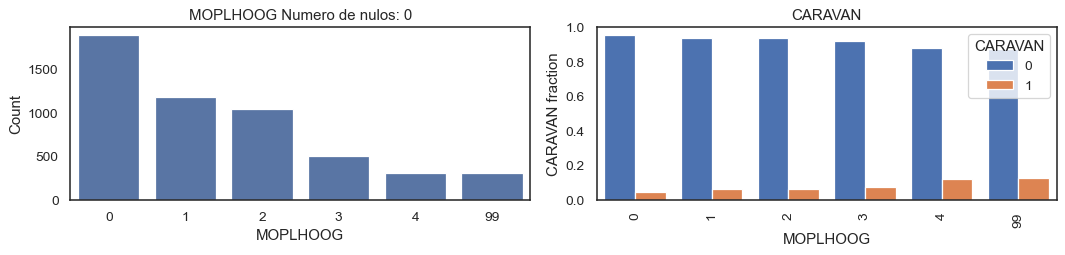

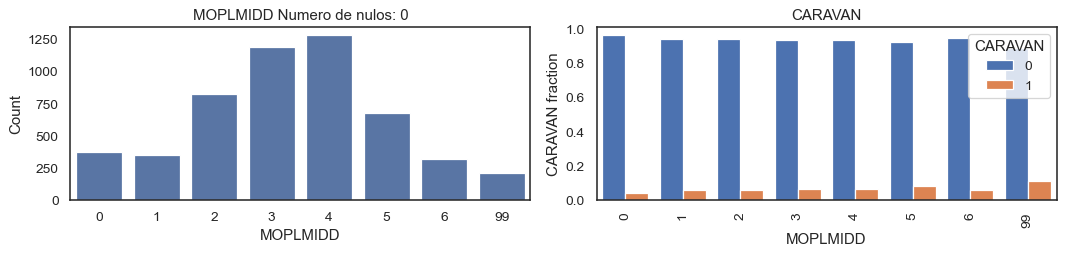

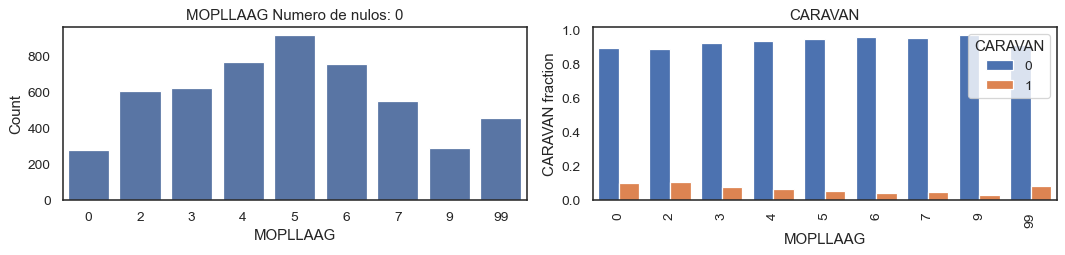

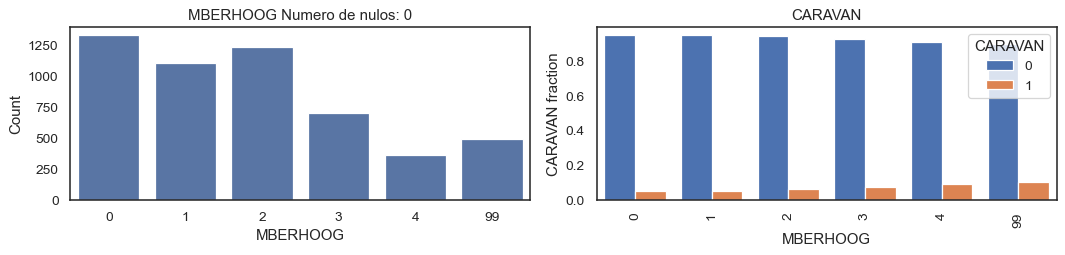

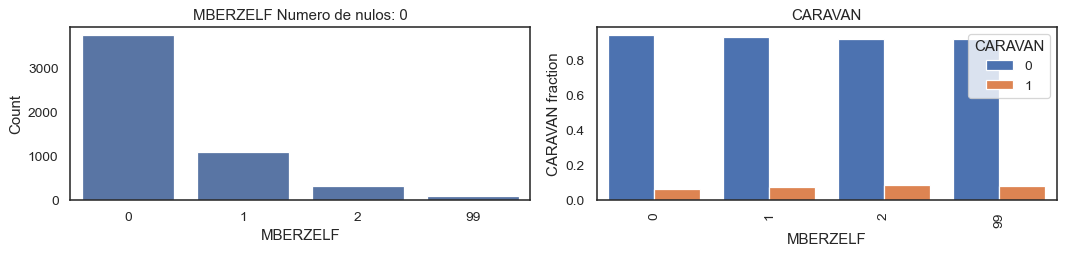

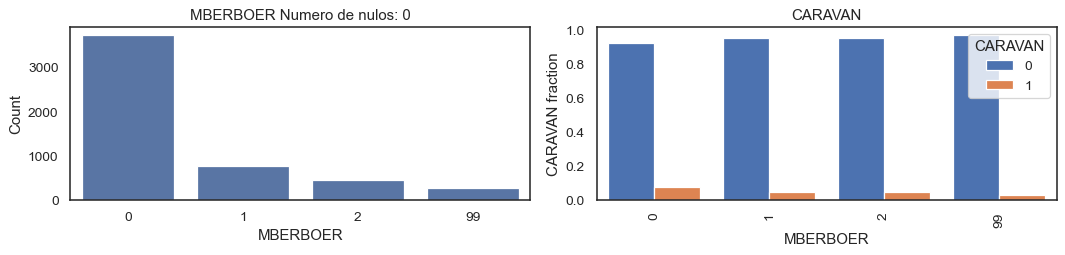

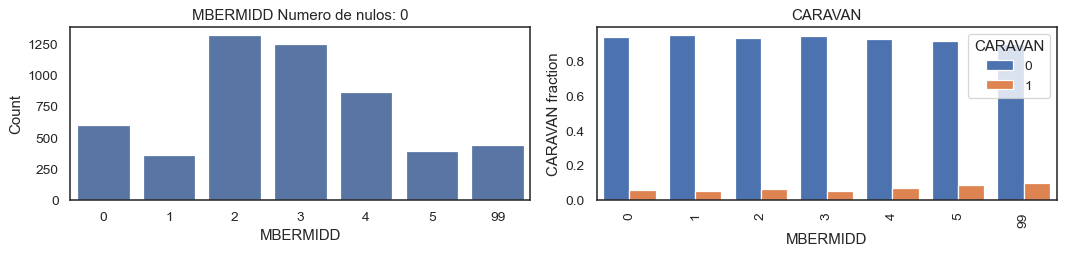

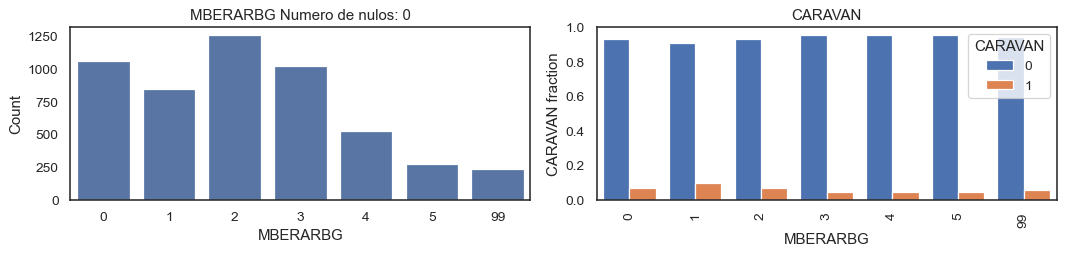

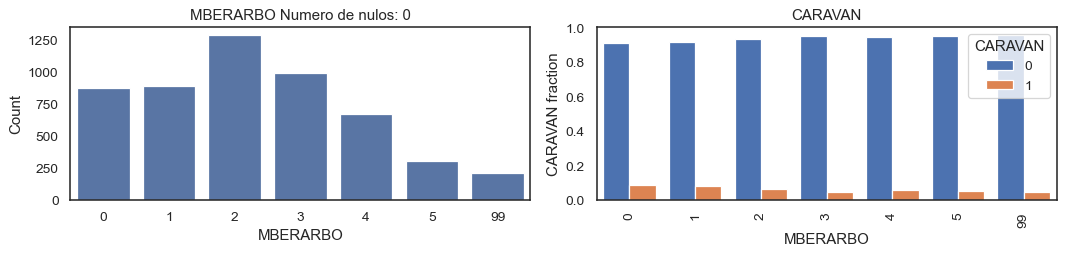

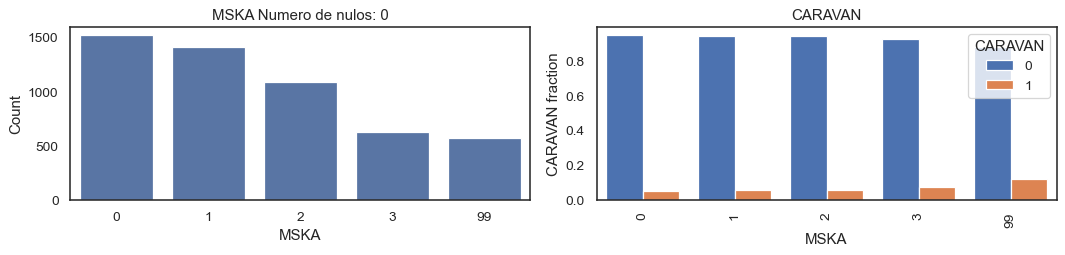

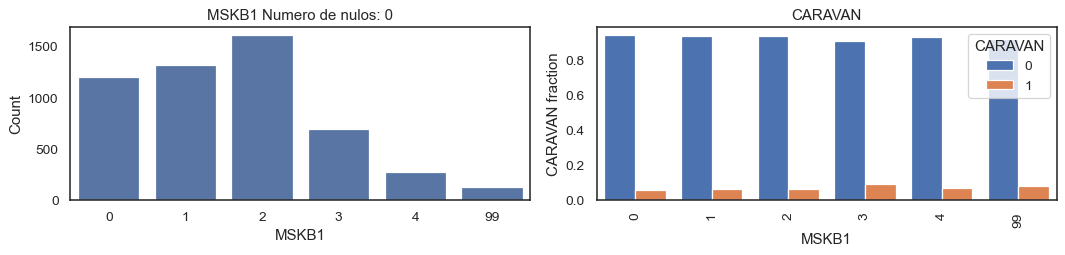

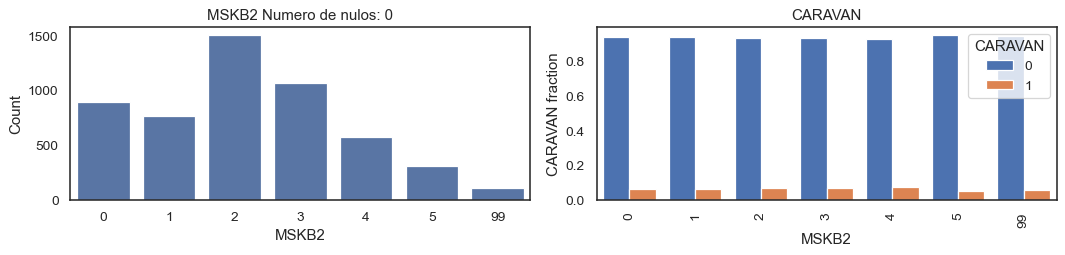

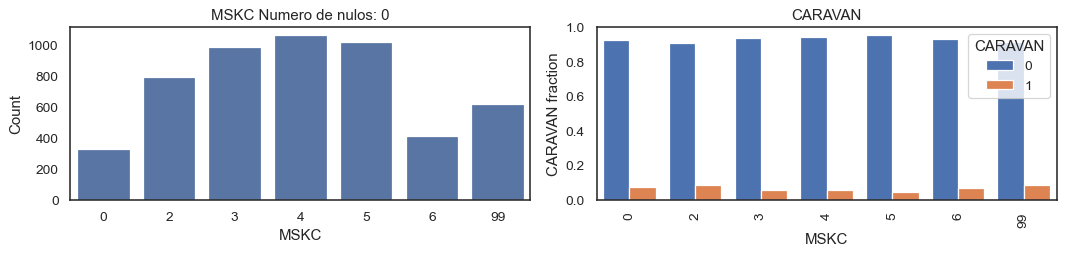

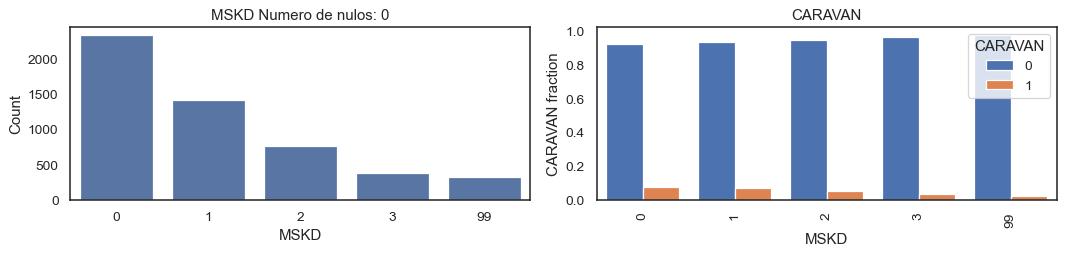

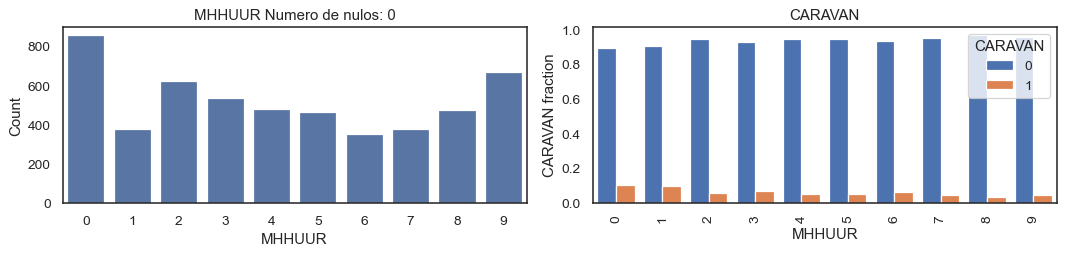

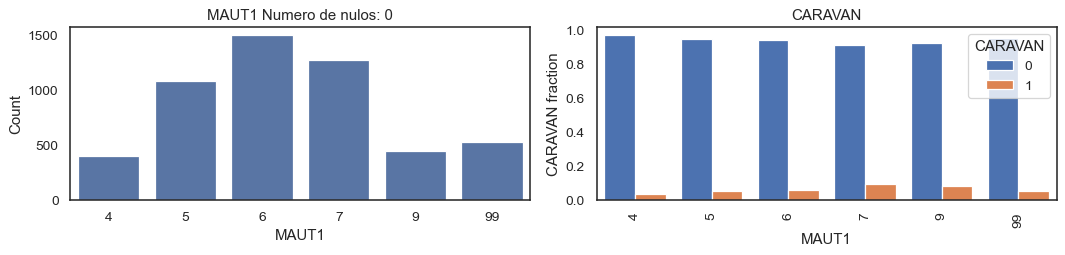

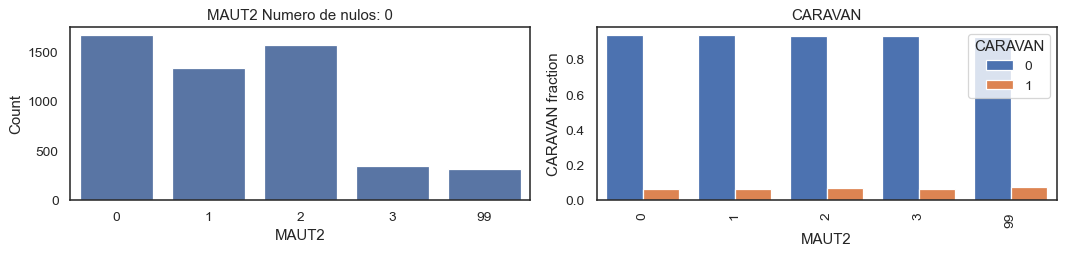

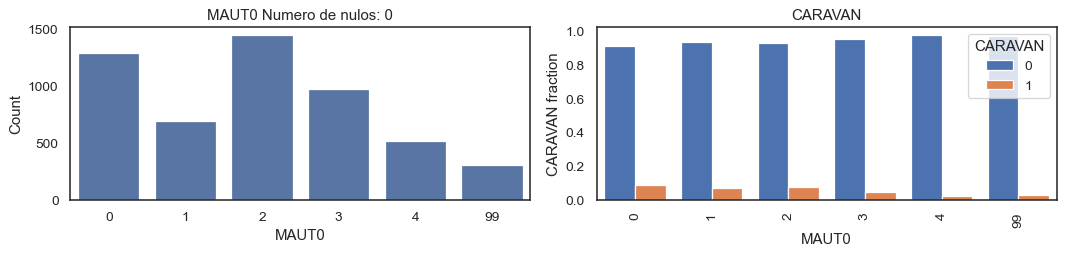

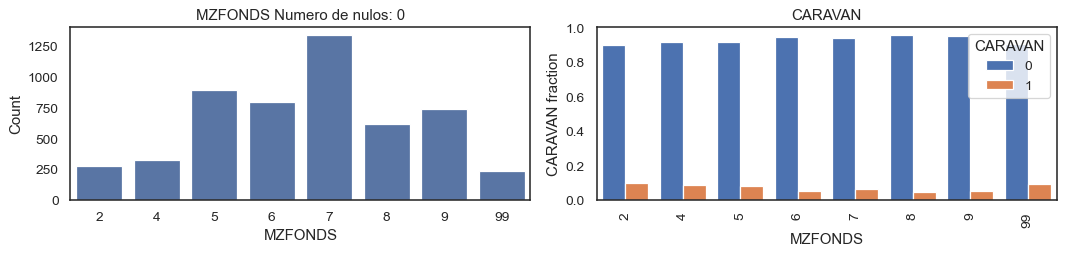

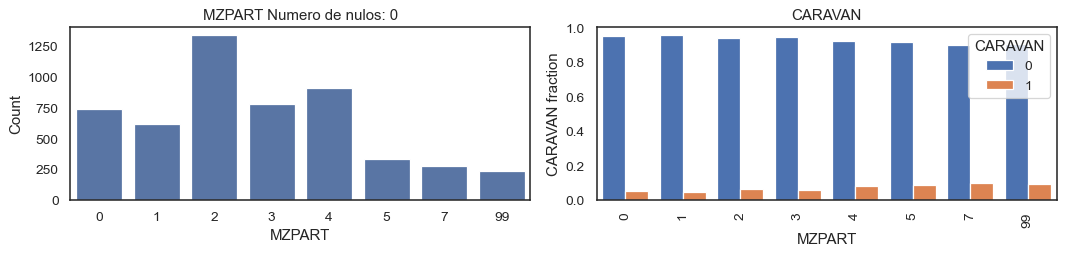

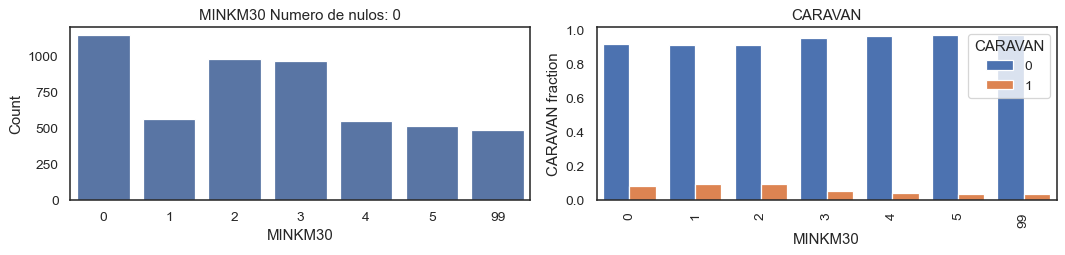

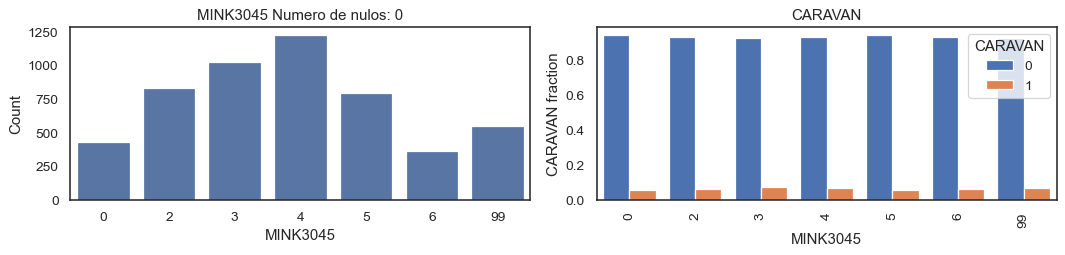

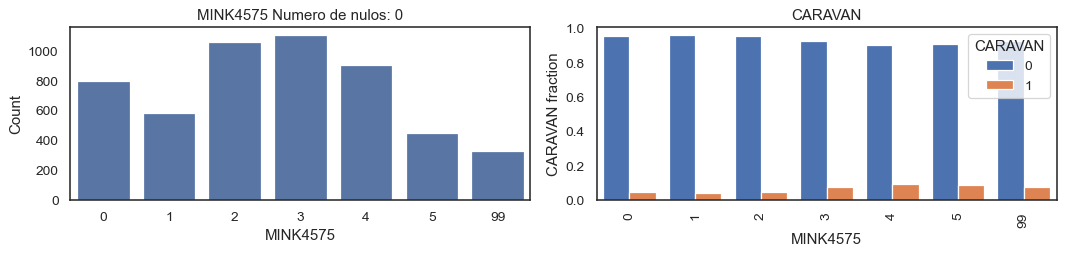

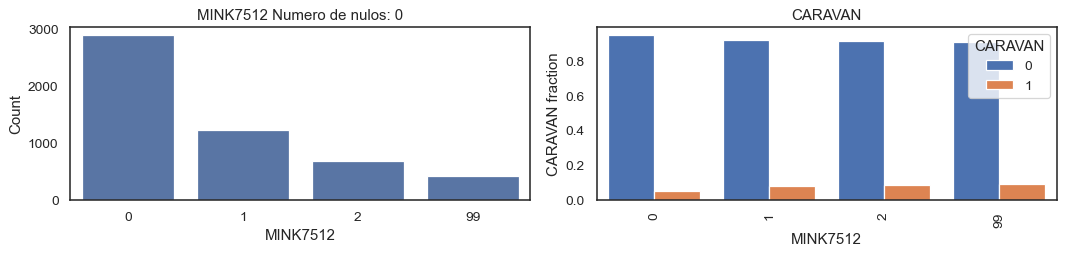

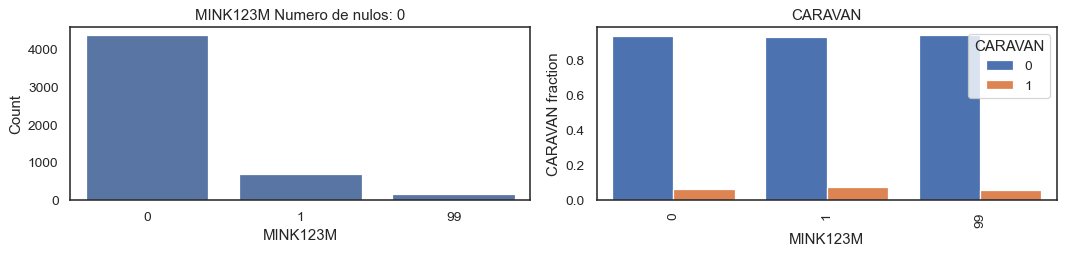

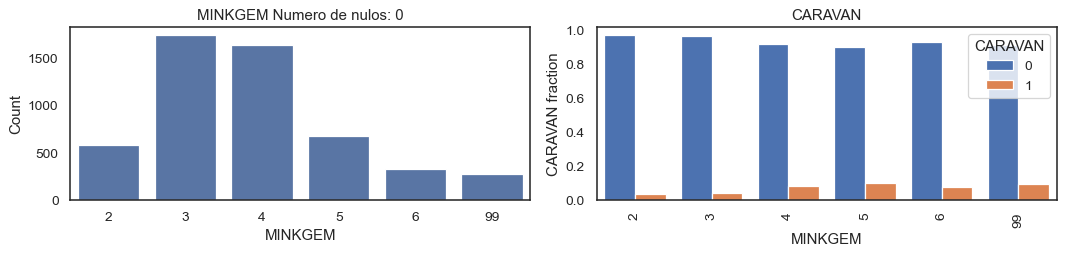

In [43]:
warnings.filterwarnings('ignore')
data_grouped['CARAVAN'] = train_data['CARAVAN']
for i in list(data_grouped.loc[:,~data_grouped.columns.isin(['CARAVAN'])]):
        plot_feature(data_grouped, col_name=i, target='CARAVAN')

In [44]:
train_data.loc[:,data_grouped.columns] = data_grouped
train_data

MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MGODRK  MGODPR  MGODOV  MGODGE  \
0          33         1        3         2       0       5       1       3   
1          99         1        2         2       1       4       1       4   
2          99         1        2         2       0       4       2       4   
3          99         1        3         3       2       3       2       4   
4          99         1        4         2       1       4       1       4   
...       ...       ...      ...       ...     ...     ...     ...     ...   
5816       99         1        2         3       0       6       0       3   
5817       99         1        1         2       0       6       1       2   
5818       99         1        4         4       1       4       1       4   
5819       33         1        3         4       0       6       0       3   
5821       33         1        3         3       0       6       1       2   

      MRELGE  MRELSA  MRELOV  MFALLEEN  MFGEKIND  MFWEKIND  MOPLHOOG  \
0          7       0       2         1         2         6         1   
1          6       2       2         0         4         5         0   
2         99       2       4         4         4         2         0   
3          5       2       2         2         3         4         3   
4          7       1       2         2         4         4        99   
...      ...     ...     ...       ...       ...       ...       ...   
5816       6       0       3         0        99         2         0   
5817      99       2      99        99         3         2         2   
5818       6       0       3         2         2         5         0   
5819       5       1       4         3         3         4         0   
5821       7       1       2         1         4         4         1   

      MOPLMIDD  MOPLLAAG  MBERHOOG  MBERZELF  MBERBOER  MBERMIDD  MBERARBG  \
0            2         7         1         0         1         2         5   
1            5         4         0         0         0         5         0   
2            5         4         0         0         0        99         0   
3            4         2         4         0         0         3         1   
4            4         0         0        99        99         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
5816        99         2         0         0         0         5         2   
5817         5         2         2         0         0         4         1   
5818         0         9         2         1         1         3         3   
5819         1        99         1         0         0         2         3   
5821         2         6         1         0         1         3         2   

      MBERARBO  MSKA  MSKB1  MSKB2  MSKC  MSKD  MHHUUR  MAUT1  MAUT2  MAUT0  \
0            2     1      1      2     6     1       1     99      0      1   
1            4     0      2      3     5     0       2      7      1      2   
2            2     0     99      0     4     0       7      7      0      2   
3            2     3      2      1     4     0       5      9      0      0   
4            0    99      0      0     0     0       4      6      2      1   
...        ...   ...    ...    ...   ...   ...     ...    ...    ...    ...   
5816         3     0      2      3     5     0       0      5      2      2   
5817         3     2      3      3     3     0       9      5      1      3   
5818         2     0      4      5     0     0       3      6      1      2   
5819         5     1      1      1     4    99       7      4      0     99   
5821         4     1      1      2     6     1       5      5      2      3   

      MZFONDS  MZPART  MINKM30  MINK3045  MINK4575  MINK7512  MINK123M  \
0           8       1        0         4         5         0         0   
1           6       3        2         0         5         2         0   
2           9       0        4         5         0         0         0   
3           7       2 

Por último, establecemos el tipo de variables a categórico

In [45]:
train_data[data_grouped.columns] = train_data[data_grouped.columns].apply(lambda x: x.astype('category'))
train_data.dtypes

MOSTYPE     category
MAANTHUI       int64
MGEMOMV        int64
MGEMLEEF    category
MGODRK      category
MGODPR      category
MGODOV      category
MGODGE      category
MRELGE      category
MRELSA      category
MRELOV      category
MFALLEEN    category
MFGEKIND    category
MFWEKIND    category
MOPLHOOG    category
MOPLMIDD    category
MOPLLAAG    category
MBERHOOG    category
MBERZELF    category
MBERBOER    category
MBERMIDD    category
MBERARBG    category
MBERARBO    category
MSKA        category
MSKB1       category
MSKB2       category
MSKC        category
MSKD        category
MHHUUR      category
MAUT1       category
MAUT2       category
MAUT0       category
MZFONDS     category
MZPART      category
MINKM30     category
MINK3045    category
MINK4575    category
MINK7512    category
MINK123M    category
MINKGEM     category
AWAPART        int64
AWABEDR        int64
AWALAND        int64
APERSAU        int64
ABESAUT        int64
AMOTSCO        int64
AVRAAUT        int64
AAANHANG     